# Analyse dynamique des déterminants des prix immobiliers et de l'impact des taux d'intérêt sur le marché du logement

In [1]:
# Project done under python 3.11.5 
# Please install openpyxl, xlrd, pandas, numpy, pyarrow, geopandas, seaborn, matplotlib, statsmodels and linearmodels

Ce projet python vise à étudier l'influence des taux d'intérêts sur les prix immobilier au niveau local en fonction de divers charactéristiques. L'objectif principal est de déterminer si l'impact des taux d'interet peut-être observé de façon homogène sur le territoire français. La question de l'effet des taux sur le marché immobilier est traité de façons assez large dans la littérature, souvent à des niveaux assez agrégé comme un pays (voir un working paper de la BCE _House prices and ultra-low interest rates: exploring the non-linear nexus_, Dieckelmann et al). Ce projet a donc la particularité de travailler à un niveau bien plus micro, l'échelon local. 

Notre analyse est limité à la période de disponibilité des données "Demandes de Valeurs Foncières" (2014-2023) qui listent toutes les transactions immobilières réalisées sur le territoire français, et nous permettent de construire des bases locales des marchés immobiliers. 

Ce notebook peut se décomposer en 3 grandes parties :

__________________________________________________

Partie I - Préparation de la DVF
 1. Récupération des données 
 2. Agrégation en utilisant des tables de passage
___________________________________________________
 
 3. Visualisation et étude des données de la DVF
___________________________________________________

Partie II - Variables de controle
 1. Récupération des données
 2. Création d'une table variable de contrôle 
 3. Visualisation des données de controle
___________________________________________________

Partie III - Analyse, modélisation et économétrie
 1. Test de Granger
 2. Corrélations 
 3. Modèles communaux
 4. Modèle avec prix dé-tendanciés
 5. Modèle ZE
 6. Modèle EPCI
____________________________________________________
Pour faciliter le contrôle de version, notre travail a été initialement réalisé sur 4 scripts indépendants ce qui représente un avantage innatendu puisque le code présent dans ce notebook peut être utilisé de façon indépendante entre 4 sections indiquées plus haut par des lignes horizontales, seule les importations des dependencies et la selection du path doivent toujours être éxécuté. 

## Les importations 

In [2]:
import pandas as pd
import numpy as np
import pyarrow.feather as feather
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import grangercausalitytests
from linearmodels import PanelOLS, RandomEffects
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.panel import compare
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore') 

In [3]:
# Change path as needed
path = "C:/Users/patry/Documents/GitHub/interestnpy" #indiquez le path vers le root du projet
#"XXX/interestnpy-main" 

## Partie I - Préparation de la DVF

### I.1. Récupération de données 

#### Création d'une table de passage

La géographie des différents agrégats locaux en France a changé entre 2014 et 2023, ce qui nécessite donc de construire une table de passage. Pour cela nous utilisons une table constante des code communes de l'INSEE que nous adaptons à trois niveaux de travail, commune, zone d'emploi et intercomunalité.

In [4]:
#IMPORTS AND FILTER INSEE TRANSLATION TABLE
passage1423_df = pd.read_excel(path+"/data/external/GEOCOM/table_passage_annuelle_2023.xlsx", 
                               sheet_name="COM", skiprows=5)
passage1423_df = passage1423_df.filter(regex='^CODGEO').iloc[:, :10]
passage1423_df = passage1423_df[passage1423_df['CODGEO_2023'].notna()]

In [5]:
#IMPORTS 2023 EPCI DEFINITIONS
fcom_df = pd.read_excel(path+"/data/external/GEOCOM/ZE2020_au_01-01-2023.xlsx", 
                            sheet_name="Composition_communale", skiprows=5)

epc_com = pd.read_excel(path+"/data/external/GEOCOM/Intercommunalite_Metropole_au_01-01-2023.xlsx", 
                            sheet_name="Composition_communale", skiprows=5)

fcom_df = pd.merge(fcom_df, epc_com, how='left', on=['CODGEO','LIBGEO', 'DEP', 'REG'])

Le niveau intercommunalité des 3 plus grandes zones métropolitaines maintient les métropoles indépendantes.

In [6]:
#CREATES COM BASED ON 2023 TOWN CODES AND ZE BASED ON EPCI
fcom_df['COM'] = fcom_df['CODGEO']
fcom_df['LIB_COM'] = fcom_df['LIBGEO']
fcom_df['ZE'] = fcom_df['ZE2020']
fcom_df['LIB_ZE'] = fcom_df['LIBZE2020']
fcom_df['EPCI'] = fcom_df['ZE2020']
fcom_df['LIB_ZE'] = fcom_df['LIBZE2020']
fcom_df['EPCI'] = fcom_df.apply(
    lambda row: row['CODGEO'] if any(x in row['LIBEPCI'] for x in ["Métropole du Grand Paris", "Métropole de Lyon", "Métropole d'Aix-Marseille-Provence"]) else row['EPCI'],
    axis=1
)
fcom_df['LIB_EPCI'] = fcom_df.apply(
    lambda row: row['LIBGEO'] if any(x in row['LIBEPCI'] for x in ["Métropole du Grand Paris", "Métropole de Lyon", "Métropole d'Aix-Marseille-Provence"]) else row['LIBEPCI'],
    axis=1
)
fcom_df['LIB_EPCI'] = fcom_df.apply(
    lambda row: "Iles-FR" if row['EPCI'] == "ZZZZZZZZZ" else row['LIB_EPCI'],
    axis=1
)
fcom_df.rename(columns={'CODGEO': 'CODGEO_2023'}, inplace=True)
fcom_df = fcom_df[['CODGEO_2023', 'COM', 'LIB_COM', 'ZE', 'LIB_ZE', 'EPCI', 'LIB_EPCI']]

In [7]:
#MERGES WITH INSEE TABLE TO CREATE THE TRANSLATION TABLE 
ident1423_df = pd.merge(passage1423_df, fcom_df, how='left', on='CODGEO_2023')

In [8]:
#FIXES PROBLEMS RELATED TO CITIES WITH "ARRONDISSEMENTS"
conditions_arr = [
    ident1423_df['CODGEO_2023'].str.startswith("75"),
    ident1423_df['CODGEO_2023'].str.startswith("132"),
    ident1423_df['CODGEO_2023'].str.startswith("6938")
]

ze_arr = [1109, 9312, 8421]
lib_arr = ["Paris", "Marseille", "Lyon"]

ident1423_df['COM'] = ident1423_df.apply(
    lambda row: row['CODGEO_2023'] if pd.isna(row['COM']) else row['COM'],
    axis=1
)

ident1423_df['EPCI'] = ident1423_df.apply(
    lambda row: row['CODGEO_2023'] if pd.isna(row['EPCI']) else row['EPCI'],
    axis=1
)
ident1423_df['EPCI'] = ident1423_df['EPCI'].astype(str)

ident1423_df['ZE'] = np.select(
  conditions_arr, 
  ze_arr, 
  default=ident1423_df['ZE'])

In [9]:
def create_lib_ident(row, col_name):
    if pd.isna(row[col_name]):
        if row['COM'][:2] == "75":
            return f"Paris {row['COM'][3:5]}"
        elif row['COM'][:2] == "69":
            return f"Lyon {int(row['CODGEO_2019']) - 80}"
        elif row['COM'][:2] == "13":
            return f"Marseille {row['COM'][3:5]}"
    else:
        return row[col_name]

In [10]:
ident1423_df['LIB_COM'] = ident1423_df.apply(create_lib_ident, col_name='LIB_COM', axis=1)

ident1423_df['LIB_EPCI'] = ident1423_df.apply(
    lambda row: row['LIB_COM'] if pd.isna(row['LIB_EPCI']) else row['LIB_EPCI'],
    axis=1
) 

ident1423_df['LIB_ZE'] = np.select(
  conditions_arr, 
  lib_arr, 
  default=ident1423_df['LIB_ZE'])

In [11]:
#REORDERS AND EXPORTS THE TRANSLATION TABLE
reord_cols = ['COM', 'ZE', 'LIB_COM', 'LIB_ZE', 'EPCI', 'LIB_EPCI']
ident1423_df = ident1423_df[reord_cols + [col for col in ident1423_df.columns if col not in reord_cols]]
ident1423_df.to_feather(path+"/data/interim/tble_de_passage_py.feather")

In [12]:
ident1423_df.head()

,COM,ZE,LIB_COM,LIB_ZE,EPCI,LIB_EPCI,CODGEO_2023,CODGEO_2022,CODGEO_2021,CODGEO_2020,CODGEO_2019,CODGEO_2018,CODGEO_2017,CODGEO_2016,CODGEO_2015,CODGEO_2014
0,13201,9312.0,Marseille 01,Marseille,13201,Marseille 01,13201,13201,13201,13201,13201,13201,13201,13201,13201,13201
1,13202,9312.0,Marseille 02,Marseille,13202,Marseille 02,13202,13202,13202,13202,13202,13202,13202,13202,13202,13202
2,13203,9312.0,Marseille 03,Marseille,13203,Marseille 03,13203,13203,13203,13203,13203,13203,13203,13203,13203,13203
3,13204,9312.0,Marseille 04,Marseille,13204,Marseille 04,13204,13204,13204,13204,13204,13204,13204,13204,13204,13204
4,13205,9312.0,Marseille 05,Marseille,13205,Marseille 05,13205,13205,13205,13205,13205,13205,13205,13205,13205,13205


#### Prix des terrains par département

Les données du Ministère de la Transition écologique sur les prix des terrains par région de 2008 à 2022 permettent à l'étape d'agrégation de soustraire les prix des terrains des montants des transactions dans les données DVF.

In [13]:
#LOADS CONVERSION TABLE REG - DEP
depreg_df = pd.read_excel(path+"/data/external/GEOCOM/table-appartenance-geo-communes-19.xls", 
                          sheet_name="COM", skiprows=5)[['DEP', 'REG']].drop_duplicates()
depreg_df['REG'] = depreg_df['REG'].astype(str)

#LOADS REGIONAL PRICES FOR LAND
ter_df = pd.read_csv(path+"/data/external/TER/1-Terrains-achetes-nombre-surface-et-prix-moyen-par-region.2022-01.csv", 
                     delimiter=";", skiprows=1, escapechar='\\', skipinitialspace=True)

In [14]:
#CREATING ADDITIONAL CONSTANT VALUES FOR 2023
additional_rows_2023 = ter_df[ter_df['ANNEE'] == 2022].copy()
additional_rows_2023['ANNEE'] = 2023
ter_df = pd.concat([ter_df, additional_rows_2023]).sort_values('ANNEE')
ter_df = ter_df[ter_df['ANNEE'] > 2013]

In [15]:
#MERGES TO GO FROM REGIONAL LEVEL TO DEPARTMENT LEVEL AND EXPORTS
terdep_df = pd.merge(depreg_df, ter_df, left_on='REG', right_on='ZONE_CODE', how='left')
terdep_df = terdep_df.dropna().reset_index(drop=True)[['ANNEE', 'DEP', 'PTM2_MED']]
terdep_df.to_feather(path+"/data/interim/terrains_py.feather")

In [16]:
terdep_df.head()

,ANNEE,DEP,PTM2_MED
0,2014.0,01,105.0
1,2015.0,01,100.0
2,2016.0,01,100.0
3,2017.0,01,103.0
4,2018.0,01,106.0


#### Inflation - Taux d'intérêt

Dans le cadre d'une analyse économique, il est préférable de travailler en euros réels, c'est-à-dire corrigé de l'inflation. Nous construisons donc une table de l'inflation cumulée depuis 2014 jusqu'à la fin du premier semestre 2023 à partir de données de l'INSEE. De l'inflation cumulée par année est extrapolée des données trimestrielles. 

In [17]:
#INFLATION TABLE
inflation = pd.read_excel(path+"/data/external/INFLATION/econ-gen-taux-inflation.xlsx", 
                          sheet_name="Données", skiprows=3, nrows=9)
inflation.rename(columns={"Année": "AN", "Taux d'inflation": "INFLATION"}, inplace=True)
inflation['AN'] = inflation['AN'].astype(str)
inflation = inflation._append({'AN': str(2023), 'INFLATION': 2.3}, ignore_index=True)
#Why 2.3? first 3 months inflation
#either way it does not matter as we will work in basis 2023
inflation.sort_values(by="AN", inplace=True)
inflation['Date'] = inflation['AN']+"0101"
inflation.loc[len(inflation)] = ["2023",0, "20230401"]
inflation['TOT'] = (1 + inflation['INFLATION'].shift(1) / 100).cumprod()
inflation['TOT'] = inflation['TOT'].fillna(1)

Les taux d'intérêts utilisés dans le cadre de ce projet ne sont pas les taux directeurs de la BCE comme cela peut-être observé dans la littérature, mais les taux de crédit immobiliers moyen observé par la Banque de France. Le projet ne cherche donc pas à étudier le délai de transmission de la politique monétaire de la BCE vers le marché immobilier français, mais directement de la transmission du taux d'intérêt effectivement pratiqué.

In [18]:
# INTEREST RATES TABLE
interest_rates = pd.read_excel(path+"/data/external/INFLATION/series_panorama_202309.xlsx", 
                               sheet_name="G3", 
                               skiprows=6, 
                               names=["Date", "ir", "ir10_avg", "ir20_avg"])

interest_rates = interest_rates[interest_rates['Date'] > '2013-12-31']

interest_rates['quarter'] = interest_rates['Date'].dt.to_period('Q').astype(str)
interest_rates = interest_rates.groupby('quarter').agg({'ir': 'mean'}).reset_index()

In [19]:
def get_month_from_quarter(quarter):
    quarter_num = quarter.split("Q")[1]
    return {'1': '01', '2': '04', '3': '07', '4': '10'}.get(quarter_num, None)

In [20]:
interest_rates['themonth'] = interest_rates['quarter'].apply(get_month_from_quarter)
interest_rates['Date'] = (interest_rates['quarter'].str[:4] + interest_rates['themonth'] + "01")
interest_rates = interest_rates[['Date', 'ir']]

In [21]:
# Combine inflation and interest rates
irflation = pd.merge(interest_rates, inflation, on='Date', how='left')
irflation = irflation.interpolate(method="slinear", fill_value="extrapolate", limit_direction="both")
irflation['BASE14'] = irflation['TOT'] / irflation['TOT'].iloc[0]
irflation['BASE23'] = irflation['BASE14'] / irflation['BASE14'].iloc[37]
irflation.to_feather(path+"/data/interim/irflation.feather")

In [22]:
irflation.head()

,Date,ir,AN,INFLATION,TOT,BASE14,BASE23
0,20140101,3.183333,2014,0.500,1.00000,1.00000,0.869350
1,20140401,3.083333,NaN,0.375,1.00125,1.00125,0.870437
2,20140701,2.883333,NaN,0.250,1.00250,1.00250,0.871524
3,20141001,2.683333,NaN,0.125,1.00375,1.00375,0.872610
4,20150101,2.506667,2015,0.000,1.00500,1.00500,0.873697


### I-2. Agrégation des données de la DVF

Dans cette partie, on agrège les données DVF trimestriellement en utilisant une fonction personnalisée à 3 niveaux distincts : commune, EPCI et zone d'emploi. Les données ont été filtrées, seul les données métropolitaines sont conservées et les transactions concernant un local commercial ou une parcelle ont été supprimées. Pour chaque niveau d'agrégation, 3 variables d'intérêt ont été gardées : le nombre de transactions, le prix médian et la part des maisons dans le total des transactions. Cette proportion est utilisée comme variable de contrôle pour les différences structurelles du marché de l'immobilier des différentes communes, car les maisons sont souvent moins chères au mètre carré que les appartements.

In [23]:
terdep_df = pd.read_feather(path+"/data/interim/terrains_py.feather")
ident_df = pd.read_feather(path+"/data/interim/tble_de_passage_py.feather").drop_duplicates()

In [24]:
def aggreg_fun(data, ID, LIB_ID):
    quantiles = data.groupby([ID, LIB_ID, 'Date', 'Type local'])['prixM2'].quantile([0.05, 0.95]).unstack()
    quantiles.columns = ['quantile_05', 'quantile_95']
    data = data.merge(quantiles, left_on=[ID, LIB_ID, 'Date', 'Type local'], right_index=True)
    filtered_data = data[(data['prixM2'] <= data['quantile_95']) & (data['prixM2'] >= data['quantile_05'])]
    data_agreg = filtered_data.groupby([ID, LIB_ID,'Date']).agg(
     n_transactions=('prixM2', 'size'),
     prop_maison=('Type local', lambda x: np.mean(x == 'Maison')),
    prixM2=('prixM2', 'median')
    ).reset_index()
    return data_agreg

Remarque : Pour réduire au maximum le poids des valeurs extrêmes ont été supprimés les 5% des prix au m2 les plus faibles et les 5% les plus élevés (par exemple, les appartements dans Paris 6e vendu à 1500€/m2 n'ont pas été pris en compte). 

In [25]:
def immo_prices(year):
    df = pd.read_csv(path+f"/data/external/DFV/valeursfoncieres-{year}.txt", delimiter="|", dtype=str)
    df = df.dropna(axis=1, how='all')  
    df = df[df['Nature mutation'] == "Vente"]
    df = df[df['Code type local'].isin(['1', '2'])]
    df = df[~df['Code departement'].isin(['971', '972', '973', '974'])]
    df['Code commune'] = df['Code commune'].str.pad(width=3, side='left', fillchar='0')
    df['depcom'] = df['Code departement'] + df['Code commune']
    df['Valeur fonciere'] = df['Valeur fonciere'].str.replace(",", ".").astype(float)
    df['quarter_num'] = df['Date mutation'].str[3:5].astype(int)
    df['qmonth'] = np.select([df['quarter_num'].isin(range(1, 4)), df['quarter_num'].isin(range(4, 7)), df['quarter_num'].isin(range(7, 10)), df['quarter_num'].isin(range(10, 13))], ["01", "04", "07", "10"], default=np.nan)
    df['Date'] = (str(year) + df['qmonth'] + "01")
    ident_year_df = ident_df[['COM', 'EPCI', 'ZE', 'LIB_COM', 'LIB_EPCI', 'LIB_ZE', f'CODGEO_{year}']].drop_duplicates()
    df = df.merge(ident_year_df, left_on='depcom', right_on=f'CODGEO_{year}', how='left')
    df = df.merge(terdep_df[terdep_df['ANNEE'] == int(year)], left_on='Code departement', right_on='DEP', how='left')
    df['Surface terrain'] = df['Surface terrain'].replace(np.nan, 0).astype(float)
    df['prixM2'] = (df['Valeur fonciere'] - df['Surface terrain'] * df['PTM2_MED']) / df['Surface reelle bati'].astype(float)
    df = df[(df['prixM2'] > 10) & (df['prixM2'] < 100000)].drop_duplicates()
    df = df.drop_duplicates(subset=['Date mutation', 'No voie', 'Valeur fonciere', 'Surface terrain', 'LIB_COM'])
    df4_epci = aggreg_fun(df,"EPCI","LIB_EPCI")
    df4_com = aggreg_fun(df,"COM", "LIB_COM")
    df4_ze = aggreg_fun(df,"ZE","LIB_ZE")
    df4_full = df.groupby('Date', as_index=False).agg(prixM2=('prixM2', 'mean'))
    return [df4_com, df4_epci, df4_ze, df4_full]

**Attention! L'agrégation ci-dessous prends entre 3 et 10 min selon le processeur**

In [26]:
years = ["2023", "2022", "2021", "2020", "2019", "2018", "2017", "2016", "2015", "2014"]
results = []

for i in years:
  print("Computing "+i)  
  results.append(immo_prices(i))

Computing 2023
Computing 2022
Computing 2021
Computing 2020
Computing 2019
Computing 2018
Computing 2017
Computing 2016
Computing 2015
Computing 2014


In [27]:
# Merging results
immo1423_com = pd.concat([result[0] for result in results])
immo1423_epci = pd.concat([result[1] for result in results])
immo1423_ze = pd.concat([result[2] for result in results])
immo1423_full = pd.concat([result[3] for result in results])

In [28]:
# Writing output
feather.write_feather(immo1423_com, path+"/data/interim/immo_panel_com_py.feather")
feather.write_feather(immo1423_epci, path+"/data/interim/immo_panel_epci_py.feather")
feather.write_feather(immo1423_ze, path+"/data/interim/immo_panel_ze_py.feather")
feather.write_feather(immo1423_full, path+"/data/interim/immo_panel_full_py.feather")

### I-3. Visualisation de données 

En utilisant des libraries comme geopandas et des shapefiles de l'INSEE nous pouvons visualiser certaines de nos données géographiques issues de la DVF. Seul le niveau zone d'emploi est considéré les autres niveaux étant trop petits pour être bien lisible sur une carte.

In [29]:
# Reading the data
ze_shp = gpd.read_file(path+"/data/external/ze2020_2023/ze2020_2023.shp")
immo_panel = pd.read_feather(path+"/data/interim/immo_panel_ze_py.feather")
immo_panel_com = pd.read_feather(path+"/data/interim/immo_panel_com_py.feather")
immo_panel_full = pd.read_feather(path+"/data/interim/immo_panel_full_py.feather")
irflation = pd.read_feather(path+"/data/interim/irflation.feather")
interest_rates = pd.read_feather(path+"/data/interim/interest_rates.feather")

In [30]:
# Data manipulation
immo_panel = immo_panel[(immo_panel['Date'] == '20230101') | 
                           (immo_panel['Date'] == '20190101') | 
                           (immo_panel['Date'].isna())]
immo_panel.sort_values(by=['ZE', 'Date'], inplace=True)
immo_panel['dprix'] = immo_panel.groupby('ZE')['prixM2'].transform(lambda x: x - x.shift())

ze_shp['ZE'] = ze_shp['ze2020'].astype(float)
full_map = ze_shp.merge(immo_panel, on="ZE", how="left")

In [31]:
# Plotting
def plot_map(data, variable, title, palette):
    fig, ax = plt.subplots(figsize=(10, 6))
    data.plot(column=variable, ax=ax, legend=True, cmap=palette,
    missing_kwds={'color': 'lightgrey', 'hatch': '///'})
    plt.title(title)
    plt.xlim(-4.5, 9.5)
    plt.ylim(41.5, 51)
    ax.set_axis_off()
    plt.show()

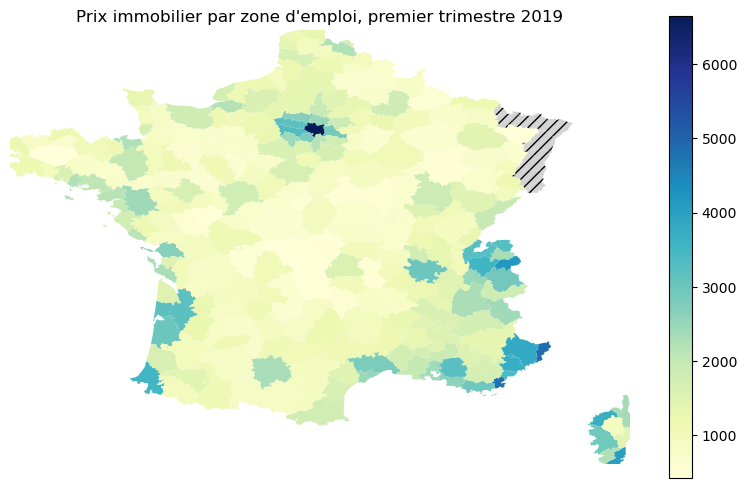

In [32]:
plot_map(full_map[(full_map['Date'] == '20190101')|(full_map['Date'].isna())], 
         'prixM2', "Prix immobilier par zone d'emploi, premier trimestre 2019", 
         "YlGnBu")

On observe une très forte hétérogénéité des prix de l'immobillier en France. Les prix sont très élevées dans la zone d'emploi de Paris et plus largement dans l'Ouest de l'Ile-de-France, ainsi que dans la Côte d'Azur. On remarque également des prix élevés dans les zones d'emploi proches de la frontière Suisse. Cela est probablement dû à la présence de travailleurs frontaliers. Au contraire, les prix immobilier sont faibles dans les zones rurales, en particulier dans le centre de la France.

Remarque: La DVF ne comprends pas de données pour une partie de l'Alsace et la Lorraine.


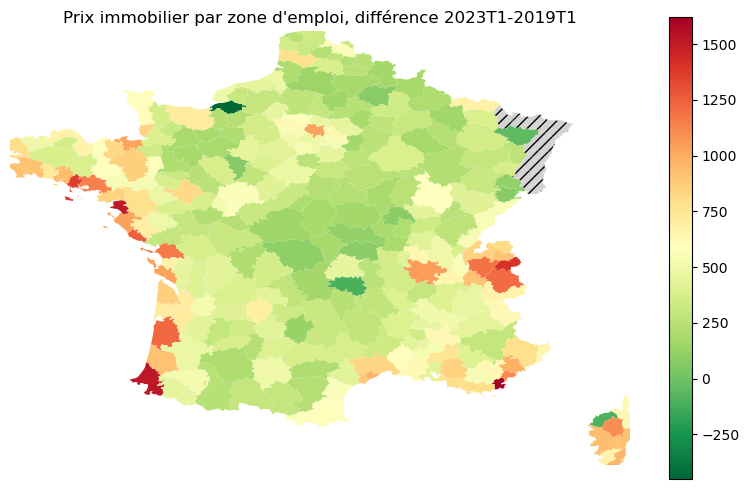

In [33]:
plot_map(full_map[(full_map['Date'] == '20230101')|(full_map['Date'].isna())], 
         'dprix', "Prix immobilier par zone d'emploi, différence 2023T1-2019T1", 
         "RdYlGn_r")

Les prix réels de l'immobilier sont stables dans l'essentiel de la France. Cependant, certains territoires ont vu de fortes augmentations. Toutes les zones d'emplois situées sur la côte atlantique ont subi des augmentations importantes tout comme celles sur la côte de la méditerannées de la région PACA. On remarque aussi une forte augmentation dans les zones d'emplois proches de la frontière Suisse. L'augmentation des prix dans la zone d'emploi de Paris entre 2019 et 2023 a été d'environ 1000€m2. Une des plus forte hausse a été dans la zone de Sainte Maxime, avec plus de 1500€m2. 

In [34]:
# Plotting time series
def plot_time_series(data, x, y, title, hue=None):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x=x, y=y, hue=hue)
    plt.title(title)
    plt.show()

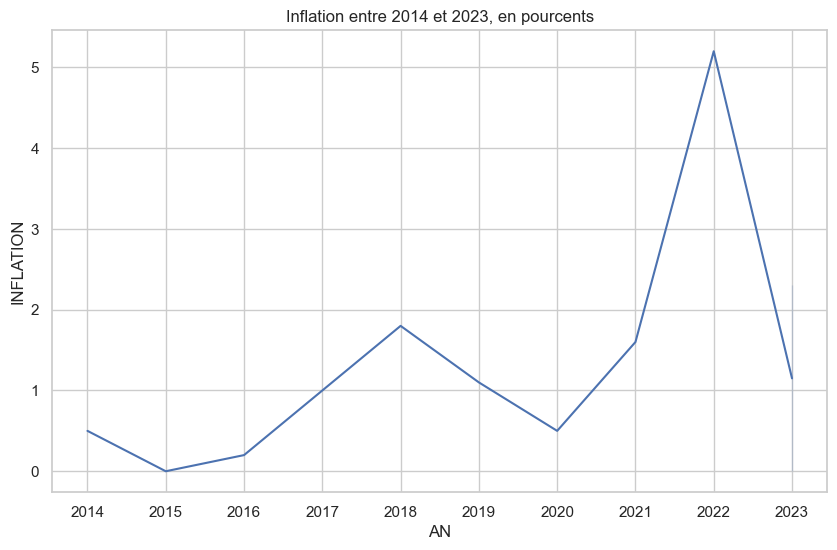

In [35]:
plot_time_series(irflation, "AN", "INFLATION", "Inflation entre 2014 et 2023, en pourcents")

On observe qu'entre 2014 et 2016, la France a connu une inflation relativement basse. Puis, de 2016 à 2018, l'inflation a légèrement augmenté pour atteindre des niveaux plus proches de l'objectif de la Banque centrale européenne (BCE) qui vise une inflation inférieure mais proche de 2%. Ensuite, la crise du Covid en 2020 a de nouveau fait baisser l'inflation. En effet, les mesures de confinement ont contribué à une baisse de la demande et à une pression à la baisse des prix. Mais en 2022, l'inflation a fortement augmenté pour atteindre les 5%, cela est lié notamment à l'invasion de l'Ukraine par la Russie. L'inflation représenté sur ce graphique en 2023 concerne uniquement le premier trimestre. 

Ainsi, l'inflation impacte nos données principalement à partir de 2021.

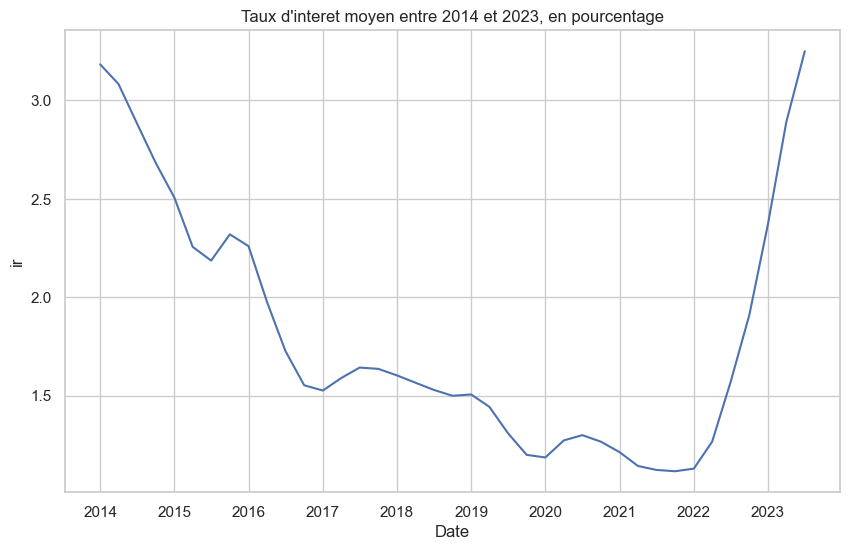

In [36]:
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'], format='%Y%m%d')
plot_time_series(interest_rates, "Date", "ir", "Taux d'interet moyen entre 2014 et 2023, en pourcentage")

Le taux d'interet moyen pratiqué sur les crédits immobiliers a varié de façon assez significative sur la période étudié, ce qui devrait nous permettre de plus facilement identifier son effet sur les marchés locaux.

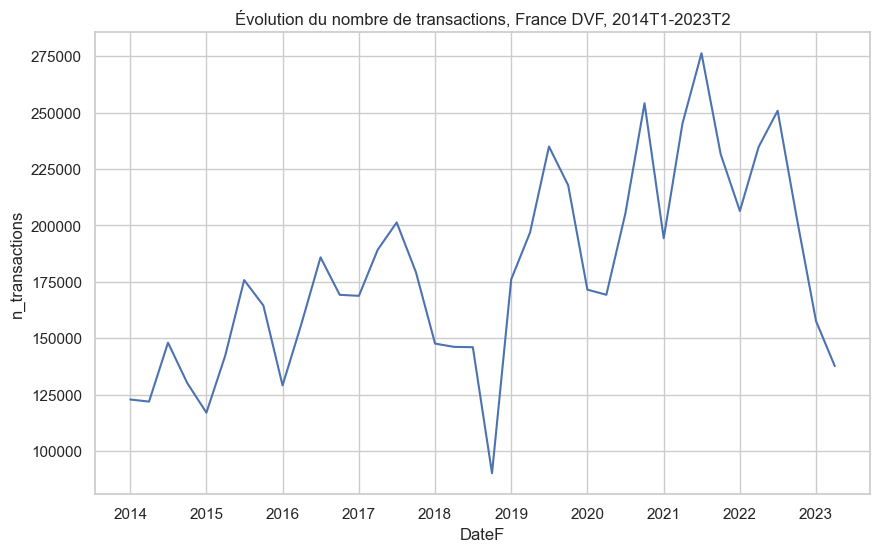

In [37]:
immo_panel_com['DateF'] = pd.to_datetime(immo_panel_com['Date'], format='%Y%m%d')
immo_panel_com_grouped = immo_panel_com.groupby('DateF').agg({'n_transactions': 'sum'}).reset_index()
plot_time_series(immo_panel_com_grouped, 'DateF', 'n_transactions', 
                 "Évolution du nombre de transactions, France DVF, 2014T1-2023T2")

Le nombre trimestriel de transacitons augmente d'années en années jusqu'au millieu de l'année 2021, qui marque le début d'une baisse prononcé des transactions. Il semble y avoir une corrélation négative entre le taux d'interet et le nombre de transactions.

In [38]:
np.corrcoef(immo_panel_com_grouped["n_transactions"], interest_rates[interest_rates["ir"]!=3.25]["ir"])

array([[ 1.        , -0.67021946],
       [-0.67021946,  1.        ]])

Cette corrélation est donc d'environ -0.67.

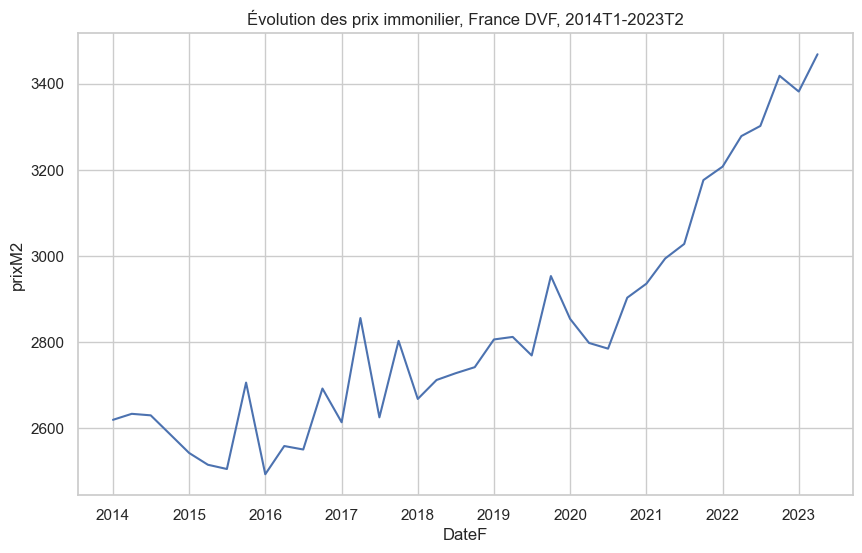

In [39]:
immo_panel_full['DateF'] = pd.to_datetime(immo_panel_full['Date'], format='%Y%m%d')
plot_time_series(immo_panel_full, 'DateF', 'prixM2', 
                 "Évolution des prix immonilier, France DVF, 2014T1-2023T2")

In [40]:
np.corrcoef(immo_panel_full["prixM2"], interest_rates[interest_rates["ir"]!=3.25]["ir"])

array([[1.        , 0.74670878],
       [0.74670878, 1.        ]])

Étonnement, il semble y avoir une corrélations positive entre le taux d'interet et les prix immobliers en France sur la période. Cependant, il s'agit très probablement d'une corrélation falacieuse liée à la non stationarité des prix immobiliers. 

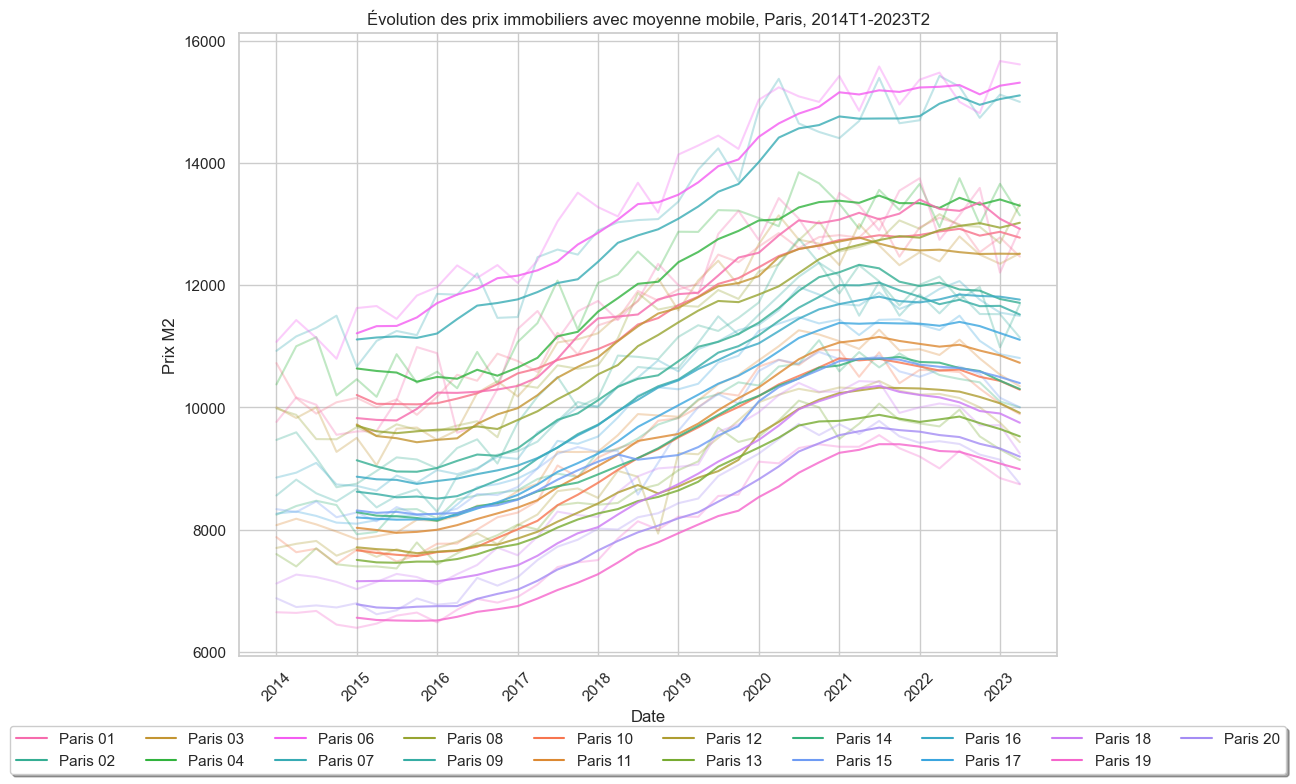

In [41]:
# Evolution des prix parisiens ---
paris_data = immo_panel_com[immo_panel_com['LIB_COM'].str.startswith('Paris ')]
paris_data = paris_data.sort_values(by='DateF')
window_size = 5  
paris_data['Moving_Average'] = paris_data.groupby('LIB_COM')['prixM2'].transform(lambda x: x.rolling(window=window_size).mean())
plt.figure(figsize=(12, 8))
palette = sns.color_palette("husl", n_colors=len(paris_data['LIB_COM'].unique()))
sns.lineplot(data=paris_data, x='DateF', y='prixM2', hue='LIB_COM',palette=palette,alpha=0.3)
sns.lineplot(data=paris_data, x='DateF', y='Moving_Average', hue='LIB_COM',palette=palette, alpha=0.8, legend=None)
plt.title('Évolution des prix immobiliers avec moyenne mobile, Paris, 2014T1-2023T2')
plt.xlabel('Date')
plt.ylabel('Prix M2')
plt.xticks(rotation=45)
sns.set_theme(style="whitegrid")
handles, labels = plt.gca().get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles[1:], labels[1:]), key=lambda t: t[1])  # Skip the first handle/label if it's the automatically generated one
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
num_items = len(handles) - 1  
num_columns_per_row = num_items // 2 + (num_items % 2 > 0)  
plt.legend(handles=sorted_handles, labels=sorted_labels, loc='upper center',
           bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True,
           ncol=num_columns_per_row)
plt.tight_layout()
plt.show()

Cependant, à un niveau micro, on remarque que dans certaines localités comme Paris les prix ont commencé à baisser.

## Partie II - Création des variables de contrôle

### II-1 Récupération des donnée

### Chômage

In [42]:
#IMPORT UNEMPLOYMENT DATA
#source https://www.insee.fr/fr/statistiques/1893230
t_passage = pd.read_feather(path+"/data/interim/tble_de_passage_py.feather")[["COM","ZE","LIB_COM", "LIB_ZE", "EPCI", "LIB_EPCI"]].drop_duplicates()
unemployement = pd.read_excel(path+"/data/external/unemployment/chomage-zone-t1-2003-t3-2023.xlsx", 
                               sheet_name="txcho_ze", skiprows=5)
unemployement_long = pd.melt(unemployement, id_vars=['ZE2020', 'LIBZE2020', 'REG', 'LIBREG'],
                             var_name='Date', value_name='UNEMP')

In [43]:
def transform_date(date):
    if date.endswith('-T1'):
        return date[:4] + '0101'
    elif date.endswith('-T2'):
        return date[:4] + '0401'
    elif date.endswith('-T3'):
        return date[:4] + '0701'
    elif date.endswith('-T4'):
        return date[:4] + '1001'
    else:
        return pd.NA

In [44]:
unemployement_long['Date'] = unemployement_long['Date'].apply(transform_date)
unemployement_long = unemployement_long[pd.to_numeric(unemployement_long['Date'], errors='coerce') > 20131231]

In [45]:
unemployement_long.head()

,ZE2020,LIBZE2020,REG,LIBREG,Date,UNEMP
13288,51,Alençon,0,INTERRÉGIONAL,20140101,9.4
13289,52,Arles,0,INTERRÉGIONAL,20140101,13.4
13290,53,Avignon,0,INTERRÉGIONAL,20140101,12.3
13291,54,Beauvais,0,INTERRÉGIONAL,20140101,10.1
13292,55,Bollène-Pierrelatte,0,INTERRÉGIONAL,20140101,12.8


### Revenus

In [46]:
#IMPORT AVAILABLE INCOME DATA  
#source https://www.insee.fr/fr/statistiques/3126151
#source https://www.insee.fr/fr/statistiques/6036907

income2014 = pd.read_excel(path+"/data/external/revenus/indic-struct-distrib-revenu-2014-COMMUNES/indic-struct-distrib-revenu-2014-COMMUNES/FILO_DISP_COM.xls", 
                               sheet_name="ENSEMBLE", skiprows=5)
income2014 = income2014[["CODGEO","Q214"]]

income2019 = pd.read_excel(path+"/data/external/revenus/indic-struct-distrib-revenu-2019-COMMUNES/FILO2019_DISP_COM.xlsx", 
                               sheet_name="ENSEMBLE", skiprows=5)
income2019 = income2019[["CODGEO","Q219", "GI19"]]

In [47]:
#MERGE 
income2014_2019 = pd.merge(income2014, income2019, how='inner', on = ["CODGEO"])

In [48]:
#ADD column Mediane_evol_diff to observe the evolution of available income between 2019 and 2019
income2014_2019["med_change"] = income2014_2019["Q219"]/income2014_2019["Q214"]
income2014_2019["CODGEO"] = income2014_2019["CODGEO"].astype(str) #preventive bug correction

In [49]:
income2014_2019.head()

,CODGEO,Q214,Q219,GI19,med_change
0,01001,21576.666667,23970,NaN,1.110922
1,01002,21672.857143,23640,NaN,1.090765
2,01004,19756.111111,20510,0.290,1.038160
3,01005,23204.800000,24050,NaN,1.036423
4,01007,21679.333333,23380,0.206,1.078446


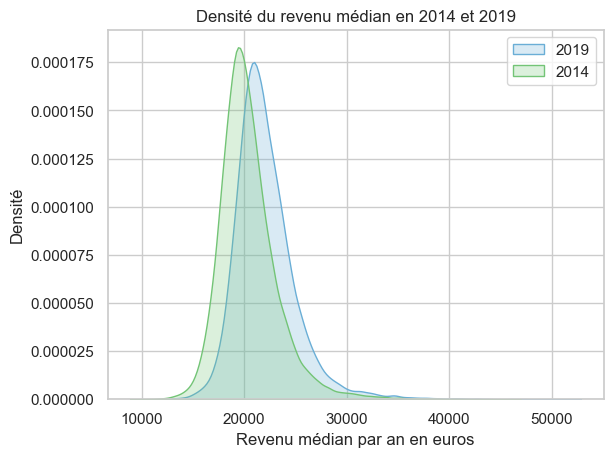

In [50]:
sns.kdeplot(income2019[["Q219"]], fill=True, label= "2019",palette='Blues')
sns.kdeplot(income2014[["Q214"]], fill=True, label = "2014",palette='Greens')
plt.xlabel('Revenu médian par an en euros')
plt.ylabel('Densité')
plt.legend()
plt.title("Densité du revenu médian en 2014 et 2019")
plt.show()

### Densité de population

In [51]:
#IMPORT POPULATION AND SURFACE
#https://www.insee.fr/fr/statistiques/7632565
population = pd.read_excel(path+"/data/external/pop_density/base-cc-serie-historique-2020.xlsx", 
                               sheet_name="COM_2020", skiprows=5)[["CODGEO","P20_POP","P14_POP", "SUPERF"]]
population = population[~population['CODGEO'].isin(["75056", "69123", "13055"])]  #Remove Paris, Lyon, Marseille                             
                               
population_arr = pd.read_excel(path+"/data/external/pop_density/base-cc-serie-historique-2020.xlsx", 
                               sheet_name="ARM_2020", skiprows=5)[["CODGEO","P20_POP","P14_POP", "SUPERF"]]

population_arr.loc[population_arr['CODGEO'] == "75112", 'SUPERF'] = 6.37 #correct for Bois de Vincennes
population_arr.loc[population_arr['CODGEO'] == "75116", 'SUPERF'] = 7.91 #correct for Bois de Boulogne


In [52]:
densite = pd.concat([population, population_arr], axis=0, ignore_index=True)
#create popdensity2014 and popdensity2020 : population/surface
densite["popdensity2014"] = densite["P14_POP"] / densite["SUPERF"]
densite["popdensity2020"] = densite["P20_POP"] / densite["SUPERF"]
densite["CODGEO"] = densite["CODGEO"].astype(str) #preventive bug correction

In [53]:
densite.head()

,CODGEO,P20_POP,P14_POP,SUPERF,popdensity2014,popdensity2020
0,01001,806,767,15.95,48.087774,50.532915
1,01002,262,239,9.15,26.120219,28.633880
2,01004,14288,14022,24.60,570.000000,580.813008
3,01005,1782,1627,15.92,102.198492,111.934673
4,01006,113,109,5.88,18.537415,19.217687


In [54]:
#MERGE INCOME2014_2019 AND DENSITE
control_var = pd.merge(income2014_2019,densite,how="inner",on=["CODGEO"])

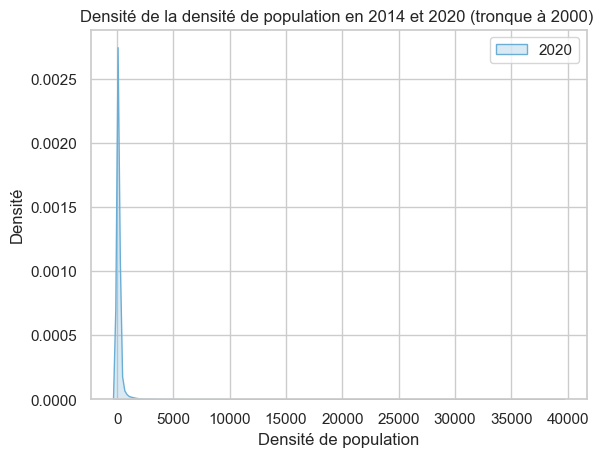

In [55]:
plt.subplot
sns.kdeplot(densite[["popdensity2020"]], fill=True, label= "2020",palette='Blues')
plt.xlabel('Densité de population')
plt.ylabel('Densité')
plt.legend()
plt.title('Densité de la densité de population en 2014 et 2020 (tronque à 2000) ')
plt.show()

### Accessibilité aux médecins généralistes

In [56]:
#IMPORT PHYSICISTS accessibility
#source https://data.drees.solidarites-sante.gouv.fr/explore/dataset/530_l-accessibilite-potentielle-localisee-apl/information/
physicist = pd.read_excel(path+"/data/external/physicist/Indicateur d'accessibilité potentielle localisée (APL) aux médecins généralistes.xlsx",sheet_name="APL_2019", skiprows=8)
physicist = physicist[["Code commune INSEE","APL aux médecins généralistes de moins de 65 ans"]]
#renaming variables 
physicist = physicist.rename(columns ={"Code commune INSEE": "CODGEO", "APL aux médecins généralistes de moins de 65 ans" : "Physicist_access"})
physicist = physicist.dropna()


In [57]:
physicist.head()

,CODGEO,Physicist_access
1,01001,2.289
2,01002,2.802
3,01004,4.469
4,01005,4.137
5,01006,0.775


In [58]:
#MERGE
control_var = pd.merge(control_var,physicist,how="inner",on="CODGEO")

### Taux de criminalité

In [59]:
#IMPORT CRIMINALITY
#source (not compressed version) https://www.data.gouv.fr/fr/datasets/bases-statistiques-communale-et-departementale-de-la-delinquance-enregistree-par-la-police-et-la-gendarmerie-nationales/#/resources
criminality = pd.read_csv(path+"/data/external/criminality/donnee-data.gouv-2022-geographie2023-produit-le2023-07-17.csv",sep=",")
criminality = criminality.rename(columns = {"CODGEO_2023":"CODGEO"})
criminality['tauxpourmille'] = criminality['tauxpourmille'].fillna(criminality['complementinfotaux'])
criminality19 = criminality[criminality["annee"].isin([19])]
criminality19['tauxpourmille'] = criminality19['tauxpourmille'].str.replace(",", ".").astype(float)

In [60]:
burglary19 = criminality19[criminality19["classe"].isin(["Cambriolages de logement"])] #around 70% of Nan in the column tauxpourmille
burglary19 = burglary19[["CODGEO","tauxpourmille"]]
burglary19 = burglary19.rename(columns = {"tauxpourmille":"burglary_for_1000"})

In [61]:
burglary19.head()

,CODGEO,burglary_for_1000
24043,01001,7.926047
24044,01002,7.926047
24045,01004,10.197461
24046,01005,14.944643
24047,01006,7.926047


In [62]:
assault19 = criminality19[criminality19["classe"].isin(["Coups et blessures volontaires"])] #around 60% of Nan in the column faits (number of occurence)
assault19= assault19[["CODGEO","tauxpourmille"]]
assault19 = assault19.rename(columns = {"tauxpourmille":"assault_for_1000"})

In [63]:
assault19.head()

,CODGEO,assault_for_1000
56283,01001,1.738796
56284,01004,7.499646
56285,01005,1.738796
56286,01006,1.738796
56287,01007,1.738796


In [64]:
otherassault19 = criminality19[criminality19["classe"].isin(["Autres coups et blessures volontaires"])] #around 45% of Nan in the column faits (number of occurence)
otherassault19= otherassault19[["CODGEO","tauxpourmille"]]
otherassault19 = otherassault19.rename(columns = {"tauxpourmille":"other_assault_for_1000"})

In [65]:
otherassault19.head()

,CODGEO,other_assault_for_1000
0,01001,0.000000
1,01004,4.386586
2,01005,0.987374
3,01006,0.987374
4,01007,0.987374


In [66]:
destruction19 = criminality19[criminality19["classe"].isin(["Destructions et dégradations volontaires"])] #around 70% of Nan in the column faits (number of occurence)
destruction19 = destruction19[["CODGEO","tauxpourmille"]]
destruction19 = destruction19.rename(columns = {"tauxpourmille":"destruction_for_1000"})

In [67]:
destruction19.head()

,CODGEO,destruction_for_1000
87006,01001,3.704983
87007,01002,3.704983
87008,01004,9.551436
87009,01005,3.704983
87010,01006,3.704983


### II-2 Création d'une table variable de contrôle 

In [68]:
#MERGE WITH control_var
control_var = pd.merge(control_var,burglary19,how="left",on="CODGEO")
control_var = pd.merge(control_var,assault19,how="left",on="CODGEO")
control_var = pd.merge(control_var,otherassault19,how="left",on="CODGEO")
control_var = pd.merge(control_var,destruction19,how="left",on="CODGEO")

In [69]:
#MERGE WITH TABLE DE PASSAGE
control_var = pd.merge(t_passage,control_var,how="right",right_on="CODGEO", left_on="COM")

In [70]:
control_var.head()

,COM,ZE,LIB_COM,LIB_ZE,EPCI,LIB_EPCI,CODGEO,Q214,Q219,GI19,...,P20_POP,P14_POP,SUPERF,popdensity2014,popdensity2020,Physicist_access,burglary_for_1000,assault_for_1000,other_assault_for_1000,destruction_for_1000
0,01001,8405.0,L'Abergement-Clémenciat,Bourg en Bresse,8405,CC de la Dombes,01001,21576.666667,23970,NaN,...,806,767,15.95,48.087774,50.532915,2.289,7.926047,1.738796,0.000000,3.704983
1,01002,8405.0,L'Abergement-de-Varey,Bourg en Bresse,8405,CC de la Plaine de l'Ain,01002,21672.857143,23640,NaN,...,262,239,9.15,26.120219,28.633880,2.802,7.926047,0.000000,0.000000,3.704983
2,01004,8405.0,Ambérieu-en-Bugey,Bourg en Bresse,8405,CC de la Plaine de l'Ain,01004,19756.111111,20510,0.290,...,14288,14022,24.60,570.000000,580.813008,4.469,10.197461,7.499646,4.386586,9.551436
3,01005,8434.0,Ambérieux-en-Dombes,Villefranche-sur-Saône,8434,CC Dombes Saône Vallée,01005,23204.800000,24050,NaN,...,1782,1627,15.92,102.198492,111.934673,4.137,14.944643,1.738796,0.987374,3.704983
4,01007,8405.0,Ambronay,Bourg en Bresse,8405,CC de la Plaine de l'Ain,01007,21679.333333,23380,0.206,...,2827,2570,33.55,76.602086,84.262295,4.714,15.860428,1.738796,0.987374,6.785714


**Définition des variables** 

| Variable | Description  |  Source | 
|---|---|---|
| Q214   | Revenu disponible médian par unité de consommation en 2014 (€)  | INSEE  | 
| Q219   | Revenu disponible médian par unité de consommation en 2014 (€) | INSEE  | 
| GI19   | Indice de Gini en 2019  | INSEE  | 
| popdensity2014   | Densité de population en 2014 (nombre d'habitants/surface)   | INSEE  | 
| popdensity2020   | Densité de population en 2020 (nombre d'habitants/surface)  | INSEE  | 
| Physicist_access   | Indicateur d'ccessibilité potentielle localisée (APL) aux médecins généralistes* | Ministère de la santé  | 
| burglary_for_1000   | Nombre de cambriolages pour 1000 habitants en 2019  | Ministère de l'intérieur  | 
| assault_for_1000   | Nombre de coups et blessures volontaires pour 1000 habitants en 2019  | Ministère de l'intérieur  | 
| other_assault_for_1000   | Nombre d'autres coups et blessures volontaires pour 1000 habitants en 2019   | Ministère de l'intérieur  | 
| destruction_for_1000  | Nombre de destructions et dégradations volontaires pour 1000 habitants en 2019   | Ministère de l'intérieur  | 

*DREES: "L’indicateur d’accessibilité potentielle localisée (APL) a été développé pour mesurer l’adéquation spatiale entre l’offre et la demande de soins de premier recours à un échelon géographique fin. C'est un indicateur local, disponible au niveau de chaque commune, qui tient compte de l’offre et de la demande issues des communes environnantes. Calculé à l’échelle communale, l’APL met en évidence des disparités d’offre de soins qu’un indicateur usuel de densité, calculé sur des mailles beaucoup plus larges aurait tendance à masquer. Il tient également compte du niveau d’activité des professionnels en exercice ainsi que de la structure par âge de la population de chaque commune qui influence les besoins de soins."

In [71]:
# Writing output
feather.write_feather(control_var, path+"/data/interim/TI_controls.feather")
feather.write_feather(unemployement_long, path+"/data/interim/TV_controls.feather")

### II-3 Visualisations supplémentaires des données de controle

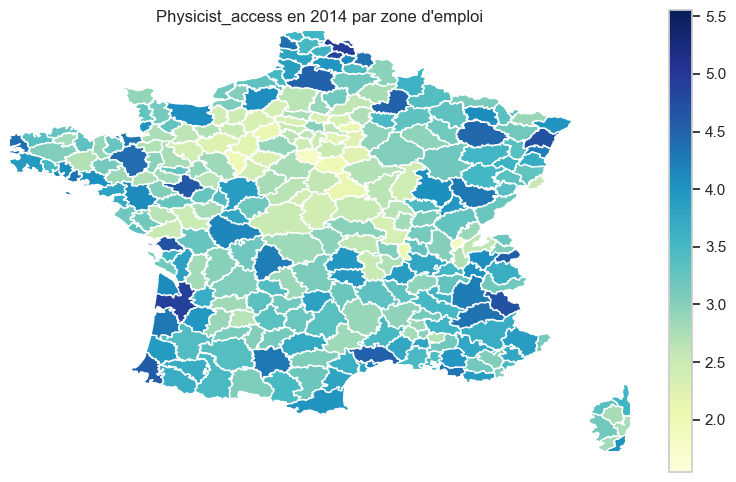

In [72]:
P14_POP_by_ZE = control_var.groupby('ZE')['P14_POP'].sum() #population niveau ZE en 2014
dfhealth = control_var
dfhealth["Physicist_access_pondere"] = control_var['Physicist_access'] * control_var["P14_POP"] #multiplie Physicist_access par la population
dfhealth = dfhealth.groupby('ZE')['Physicist_access_pondere'].sum() 
dfhealth = pd.merge(dfhealth,P14_POP_by_ZE,on="ZE")
dfhealth["Physicist_access_ZE"] = dfhealth["Physicist_access_pondere"]/dfhealth["P14_POP"]
dfhealth = dfhealth[["Physicist_access_ZE"]]
dfhealth["Physicist_access_ZE"] = dfhealth["Physicist_access_ZE"].astype(float)
 
full_map3 = ze_shp.merge(dfhealth, on="ZE", how="left")




plot_map(full_map3, 
         'Physicist_access_ZE', "Physicist_access en 2014 par zone d'emploi", 
         "YlGnBu")

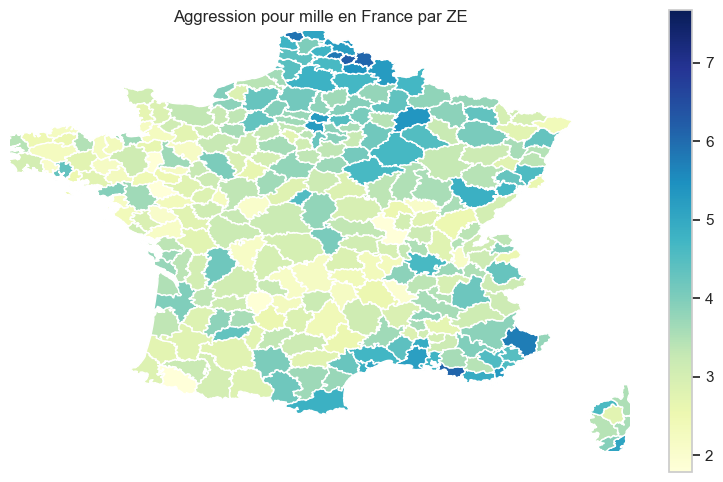

In [73]:
dassault = control_var
dassault["assault_for_1000_pondere"] = control_var['assault_for_1000'] * control_var["P14_POP"] #multiplie Physicist_access par la population
dassault = dassault.groupby('ZE')['assault_for_1000_pondere'].sum() 
dassault = pd.merge(dassault,P14_POP_by_ZE,on="ZE")
dassault["assault_for_1000_ZE"] = dassault["assault_for_1000_pondere"]/dassault["P14_POP"]
dassault = dassault[["assault_for_1000_ZE"]]
dassault["assault_for_1000_ZE"] = dassault["assault_for_1000_ZE"].astype(float)
 
full_map3 = ze_shp.merge(dassault, on="ZE", how="left")




plot_map(full_map3, 
         'assault_for_1000_ZE', "Aggression pour mille en France par ZE", 
         "YlGnBu")

## Partie III - Modélisation économétrique

Dans cette section consacrée à la modélisation, nous ferons appel à des méthodes économétriques afin de tenter de répondre à la problématique centrale de ce projet : dans quelle mesure la hausse récente des taux d'intérêt impacte-t-elle différemment les marchés immobiliers locaux en fonction des caractéristiques de chaque ville ?

Comme mentionné dans les sections précédentes, la disponibilité des variables d'intérêt sous une forme évolutive dans le temps est limitée, ce qui contraint l'usage de méthodes de séries temporelles en panel telles que les PVAR. Par conséquent, nous privilégions des méthodes classiques d'économétrie de panel, telles que les modèles à effets fixes.

Le modèle principal de cette analyse est un modèle à effets fixes. Il intègre comme variables d'intérêt le retard (lag) du taux d'intérêt en interaction avec différentes caractéristiques locales, tout en contrôlant les effets annuels et la structure des transactions effectuées. Des modèles supplémentaires à différents niveaux géographiques sont estimés pour tester la robustesse de nos résultats.

Les prix immobiliers utilisés sont exprimés, sauf indication contraire, en euros 2014.

In [74]:
# Custom Functions
def merge_and_transform(base_df, irflation_df, control_df, base_col, min_transactions=30, required_count=38):
    base_df=base_df.drop(columns=["LIB_"+base_col])
    df = base_df[base_df['n_transactions'] > min_transactions]
    df['n'] = df.groupby(base_col)[base_col].transform('count')
    df = df[df['n'] == required_count].drop(columns='n')
    df = df.merge(irflation_df, on='Date', how='left')
    df = df.merge(control_df, on=base_col, how='left')
    df['prixM2'] = df['prixM2'] / df['BASE14']
    df['log_prixM2'] = np.log(df['prixM2'])
    df['Q219'] = df['Q219'] / irflation['BASE14'][20]
    df['med_change'] = (df['Q219'] / irflation_df['BASE14'][20]) - (df['Q214'] / irflation_df['BASE14'][0])
    df['dens_change'] = df['popdensity2020'] - df['popdensity2014']
    return df

In [75]:
def group_and_calculate_diff(df, group_cols):
    df = df.sort_values(by=group_cols + ['Date'])
    grouped = df.groupby(group_cols)
    df['diff_prixM2'] = grouped['prixM2'].diff().fillna(np.nan)
    df['diff2_prixM2'] = grouped['prixM2'].diff().diff().fillna(np.nan)
    df['year'] = df['Date'].str[:4]
    df['trim'] = df['Date'].str[5:6]
    df['diff2_prop_maison'] = grouped['prop_maison'].diff().fillna(np.nan)
    df['diff_ir'] = grouped['ir'].diff().fillna(np.nan)
    df['lag_ir'] = grouped['ir'].shift(1)
    df['lag2_ir'] = grouped['ir'].shift(2)
    df['lag3_ir'] = grouped['ir'].shift(3)
    df['lag4_ir'] = grouped['ir'].shift(4)
    df['diff_lag_ir'] = grouped['lag_ir'].diff().fillna(np.nan)
    df['diff2_lag_ir'] = grouped['lag_ir'].diff().diff().fillna(np.nan)
    
    for var in ['popdensity2020', 'med_change', 'Physicist_access', 'Q219', 'prop_maison', 'assault_for_1000', 'dens_change']:
      df[f'lag3_ir_{var}'] = df['lag3_ir'] * df[var]
    df['prixM2_FE'] = grouped['prixM2'].transform(lambda x: x - x.mean()) #Within transformation
    df['log_prixM2_FE'] = grouped['log_prixM2'].transform(lambda x: x - x.mean()) #Within transformation
    df['lag3_ir_FE'] = grouped['lag3_ir'].transform(lambda x: x - x.mean()) #Within transformation
    df['prop_maison_FE'] = grouped['prop_maison'].transform(lambda x: x - x.mean()) #Within transformation
    df['popdensity2020_ir_FE'] = grouped['lag3_ir_popdensity2020'].transform(lambda x: x - x.mean()) #Within transformation
    df['med_change_ir_FE'] = grouped['lag3_ir_med_change'].transform(lambda x: x - x.mean()) #Within transformation
    df['Physicist_access_ir_FE'] = grouped['lag3_ir_Physicist_access'].transform(lambda x: x - x.mean()) #Within transformation
    df['Q219_ir_FE'] = grouped['lag3_ir_Q219'].transform(lambda x: x - x.mean()) #Within transformation
    df['prop_maison_ir_FE'] = grouped['lag3_ir_prop_maison'].transform(lambda x: x - x.mean()) #Within transformation
    df['assault_for_1000_ir_FE'] = grouped['lag3_ir_assault_for_1000'].transform(lambda x: x - x.mean()) #Within transformation
    df['dens_change_ir_FE'] = grouped['lag3_ir_dens_change'].transform(lambda x: x - x.mean()) #Within transformation
    return df.reset_index(drop=True)

In [76]:
def run_regression(df, formula):
    model = smf.ols(formula, data=df)
    results = model.fit()
    return(results)

In [77]:
def aggregate_data(df, group_cols, agg_dict):
    agg_df = df.groupby(group_cols).agg(agg_dict).reset_index()
    agg_df['popdensity2020'] = agg_df['P20_POP'] / agg_df['SUPERF']
    agg_df['popdensity2014'] = agg_df['P14_POP'] / agg_df['SUPERF']
    return agg_df.drop(columns=['P20_POP', 'P14_POP', 'SUPERF'])

In [78]:
def corplot(df, nom):
  plt.figure(figsize=(10, 8))
  sns.heatmap(df, annot=True, cmap='coolwarm')
  plt.title('Correlations intra-ville pour '+nom)
  plt.show()

In [79]:
def cor_ville(df, nom):
  df = df[df['LIB_COM']==nom]
  df = df[["prixM2", "ir","lag_ir","lag2_ir","lag3_ir","lag4_ir", "prop_maison"]].dropna().corr()
  return(df)

In [80]:
# Reading Data
base_path = path + "/data/interim/"
immo_epci = pd.read_feather(base_path + "immo_panel_epci_py.feather")
immo_ze = pd.read_feather(base_path + "immo_panel_ze_py.feather")
immo_com = pd.read_feather(base_path + "immo_panel_com_py.feather")
immo_full = pd.read_feather(base_path + "immo_panel_full_py.feather")
unemployment = pd.read_feather(base_path + "TV_controls.feather")
control = pd.read_feather(base_path + "TI_controls.feather")
irflation = pd.read_feather(base_path + "irflation.feather")

In [81]:
# Aggregate data
agg_dict_control = {
    'Q219': 'mean', 'Q214': 'mean',
    'P20_POP': 'sum', 'P14_POP': 'sum',
    'SUPERF': 'sum', 'Physicist_access': 'mean',
    'assault_for_1000': 'mean'
}
control_ze = aggregate_data(control, ['ZE', 'LIB_ZE'], agg_dict_control)
control_epci = aggregate_data(control, ['EPCI', 'LIB_EPCI'], agg_dict_control)

In [82]:
control_ze

,ZE,LIB_ZE,Q219,Q214,Physicist_access,assault_for_1000,popdensity2020,popdensity2014
0,51.0,Alençon,20997.962963,19513.189514,2.082500,1.755776,55.113269,56.711867
1,52.0,Arles,21809.000000,19972.087654,3.420800,3.236450,72.920998,73.127843
2,53.0,Avignon,22300.000000,20545.182303,3.394056,2.740536,417.644716,410.739621
3,54.0,Beauvais,22776.977492,21354.075800,2.484302,2.126033,101.060545,99.605781
4,55.0,Bollène-Pierrelatte,22470.000000,20853.342050,2.636862,2.360175,116.635591,114.159934
...,...,...,...,...,...,...,...,...
292,9403.0,Calvi,20157.692308,17556.055940,2.501885,2.770986,30.841287,29.282792
293,9404.0,Corte,19877.619048,18417.861064,2.302619,2.429574,17.854459,17.851954
294,9405.0,Ghisonaccia,19199.500000,17423.182708,1.318500,2.395572,21.200251,20.658202
295,9406.0,Porto-Vecchio,20430.000000,18183.271573,3.065545,3.696087,29.525449,28.948056


In [83]:
# Processing for immo_reg_com
immo_reg_com = merge_and_transform(immo_com, irflation, control, 'COM')
immo_reg_com_diff = group_and_calculate_diff(immo_reg_com, ['COM'])

Pour obtenir un panel équilibré avec des prix au m2 suffisament stable nous gardons uniquement les villes, les ZE et les EPCI qui ont eu au moins 30 transactions par trimestre. Cela a un impact sur la distribution des prix dans notre sample, en ce qui concerne les villes, les deux densités sont représentées ci-dessous.

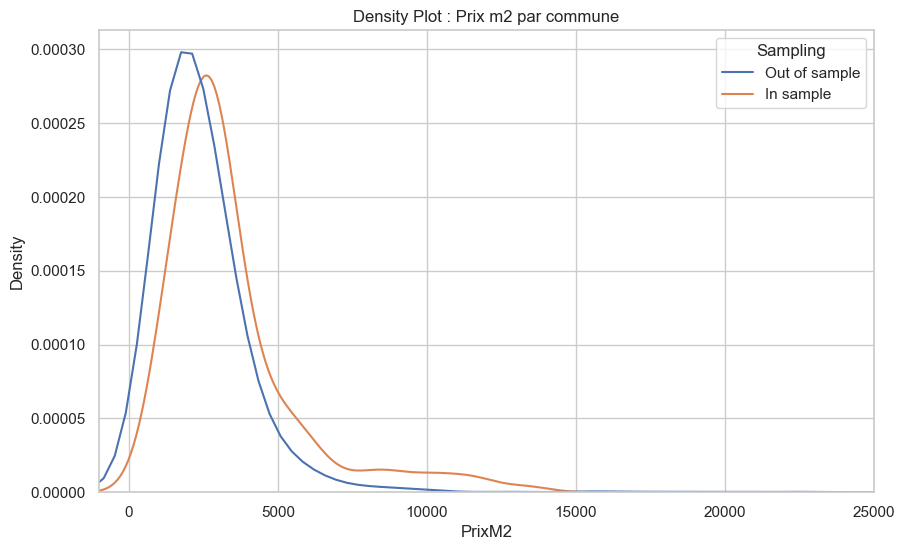

In [84]:
filtered_data = immo_com[immo_com['n_transactions'] > 30][['COM', 'Date', 'prixM2', 'prop_maison', 'n_transactions']]
merged_data = filtered_data.merge(irflation, on='Date', how='left').merge(control, on='COM', how='left')
grouped = merged_data.groupby('COM').agg(
    n=('n_transactions', lambda x: (x > 30).sum()),
    popdensity2020=('popdensity2020', 'mean'),
    prixM2=('prixM2', 'mean')
).reset_index()
grouped['Sampling'] = grouped['n'].apply(lambda x: 'In sample' if x == 38 else 'Out of sample')
plt.figure(figsize=(10, 6))
ax=sns.kdeplot(data=grouped, x='prixM2', hue='Sampling', common_norm=False)
plt.title('Density Plot : Prix m2 par commune')
plt.xlabel('PrixM2')
plt.ylabel('Density')
ax.set_xlim(-1000, 25000)
plt.show()

L'effet est encore plus marqué pour les densités. 

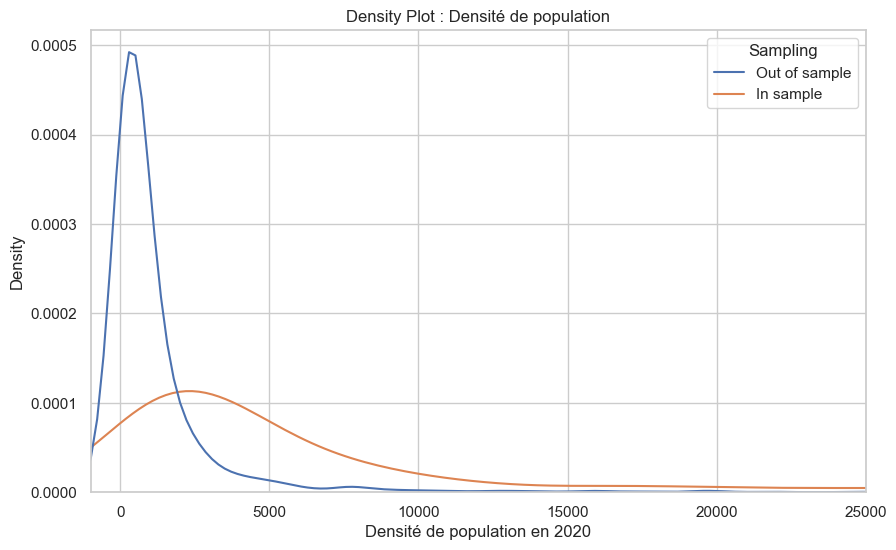

In [85]:
plt.figure(figsize=(10, 6))
ax=sns.kdeplot(data=grouped, x='popdensity2020', hue='Sampling', common_norm=False)
plt.title('Density Plot : Densité de population')
plt.xlabel('Densité de population en 2020')
plt.ylabel('Density')
ax.set_xlim(-1000, 25000)
plt.show()

Ainsi, il faut considérer que nos résultats ne sont pas représentatifs de l'ensemble des marchés immobiliers français mais uniquement des marchés immobiliers assez actifs.

In [86]:
# Processing for immo_reg_ze
immo_reg_ze = merge_and_transform(immo_ze, irflation, control_ze, 'ZE')
immo_reg_ze_diff = group_and_calculate_diff(immo_reg_ze, ['ZE', 'LIB_ZE'])
immo_reg_ze_diff = immo_reg_ze_diff.merge(unemployment[['ZE2020', 'Date', 'UNEMP']], left_on=['ZE', 'Date'], right_on=['ZE2020', 'Date'], how='left')
immo_reg_ze_diff['lag3_UNEMP'] = immo_reg_ze_diff.groupby(['ZE', 'LIB_ZE'])['UNEMP'].shift(3)
immo_reg_ze_diff['lag3_UNEMP_ir'] = immo_reg_ze_diff['lag3_UNEMP']*immo_reg_ze_diff['lag3_ir'] 
grouped = immo_reg_ze_diff.groupby(['ZE', 'LIB_ZE'])
immo_reg_ze_diff['lag3_UNEMP_FE'] = grouped['lag3_UNEMP'].transform(lambda x: x - x.mean()) #Within transformation
immo_reg_ze_diff['lag3_UNEMP_ir_FE'] = grouped['lag3_UNEMP_ir'].transform(lambda x: x - x.mean()) #Within transformation

In [87]:
# Processing for immo_reg_epci
immo_reg_epci = merge_and_transform(immo_epci, irflation, control_epci, 'EPCI')
immo_reg_epci_diff = group_and_calculate_diff(immo_reg_epci, ['EPCI', 'LIB_EPCI'])

### Test de Granger

Le marché immobilier, étant moins liquide que les marchés financiers, ne révèle l'impact du taux d'intérêt sur les prix qu'après un certain délai. Il est courant dans la littérature de considérer le retard du taux d'intérêt plutôt que le taux lui-même, comme illustré par Harris (1989) dans _The Effect of Real Rates of Interest on Housing Prices_. Cependant, cette transmission varie selon les caractéristiques des marchés immobiliers et le contexte macroéconomique. Ainsi, pour déterminer le nombre approprié de retards du taux d'intérêt dans l'analyse des marchés locaux en France, nous employons un test de Granger. Ce test évalue si une série temporelle améliore la prédiction d'une autre série temporelle et, par conséquent, si elle est pertinente pour son analyse. $$\Delta ({p}/m^{2})_t \sim \Delta L^n(i_t)$$ Nous cherchons à déterminer si l'utilisation du taux d'intérêt avec plusieurs retards apporte des informations sur les prix immobiliers. L'hypothèse nulle est l'absence de pouvoir prédictif. Pour obtenir des séries stationnaires, nous utilisons la différence. Bien qu'il existe des méthodes pour généraliser le test de Granger à des données en panel (Holtz-Eakin et al., 1988), celles-ci n'ont pas été développées en Python. Pour obtenir une idée générale du nombre de retards requis, nous appliquons le test à quelques villes de tailles variées choisies aléatoirement.

In [88]:
# Granger Causality Test
for i in ["Paris 14","Clermont-Ferrand","Le Grau-du-Roi", "Cagnes-sur-Mer", "Savigny-sur-Orge"]:
  print(i)
  granger_test3 = grangercausalitytests(immo_reg_com_diff[immo_reg_com_diff["LIB_COM"]==i][['diff_prixM2', 'diff_ir']].dropna(), maxlag=5, verbose=True)

Paris 14

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7132  , p=0.0372  , df_denom=33, df_num=1
ssr based chi2 test:   chi2=5.1417  , p=0.0234  , df=1
likelihood ratio test: chi2=4.8061  , p=0.0284  , df=1
parameter F test:         F=4.7132  , p=0.0372  , df_denom=33, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9161  , p=0.1648  , df_denom=30, df_num=2
ssr based chi2 test:   chi2=4.4709  , p=0.1069  , df=2
likelihood ratio test: chi2=4.2075  , p=0.1220  , df=2
parameter F test:         F=1.9161  , p=0.1648  , df_denom=30, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8979  , p=0.0533  , df_denom=27, df_num=3
ssr based chi2 test:   chi2=10.9478 , p=0.0120  , df=3
likelihood ratio test: chi2=9.4908  , p=0.0234  , df=3
parameter F test:         F=2.8979  , p=0.0533  , df_denom=27, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7984  , p=0.162

Il apparaît que, selon la commune, si un effet existe, entre 1 et 3 trimestres sont nécessaires pour que le taux d'intérêt ait un pouvoir explicatif sur les prix immobiliers.

### Corrélations

Afin d'observer les interactions entre les variables d'intérêt choisies et d'obtenir une première impression de ce que la modélisation peut apporter, il est utile de construire des matrices de corrélations. D'abord, une matrice pour l'ensemble du panel, puis pour les trois premières villes utilisées lors du test de Granger.

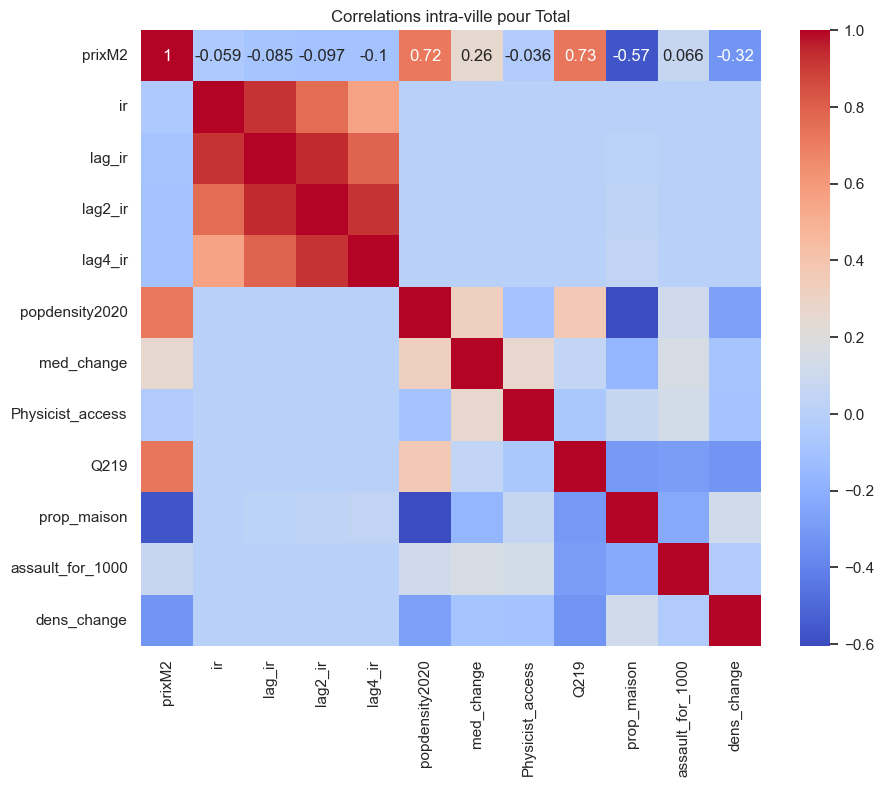

In [89]:
# Total 
immo_reg_corr =immo_reg_com_diff[["prixM2", "ir","lag_ir","lag2_ir","lag4_ir","popdensity2020", "med_change", "Physicist_access", "Q219", "prop_maison", "assault_for_1000", "dens_change"]].dropna().corr()
corplot(immo_reg_corr, "Total")

Cette matrice révèle une corrélation relativement faible entre les prix et le taux d'intérêt, quel que soit le nombre de retards. En revanche, les corrélations sont significatives entre les prix et la densité en 2020, l'évolution des revenus médians dans la commune, la proportion de maisons dans le total des transactions, et les changements de densité. La faible corrélation entre le taux d'intérêt et les prix s'explique probablement par la dimension NN de notre panel, bien plus importante que la dimension TT, le taux d'intérêt étant identique pour toutes les villes à chaque période.

Pour vérifier cela, il est possible d'établir des matrices de corrélations pour quelques villes, en excluant les variables constantes dans le temps. Par exemple, pour le 14e arrondissement de Paris : 

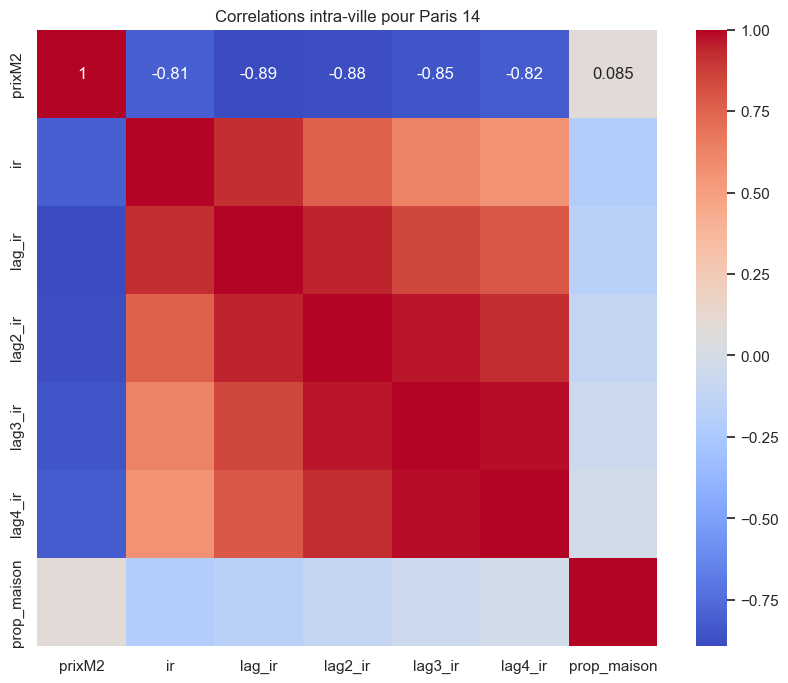

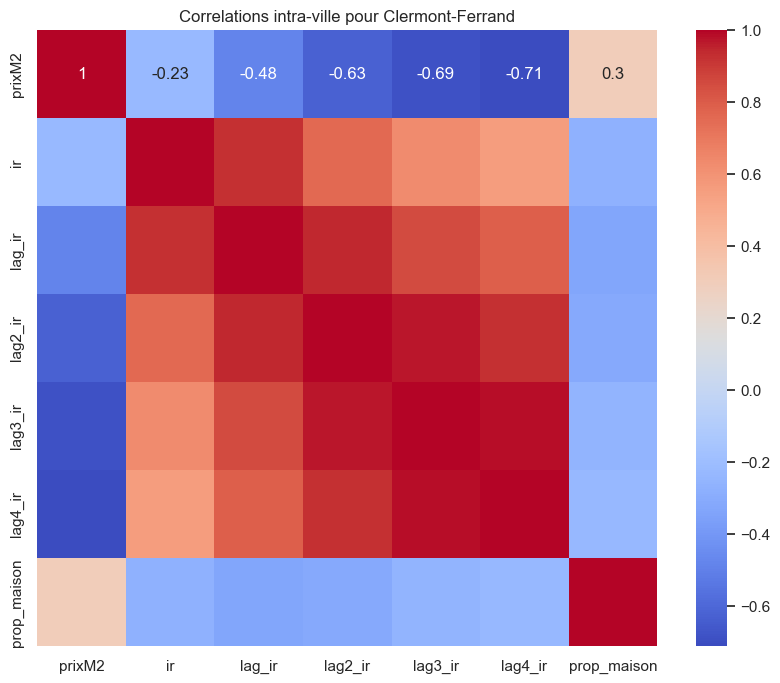

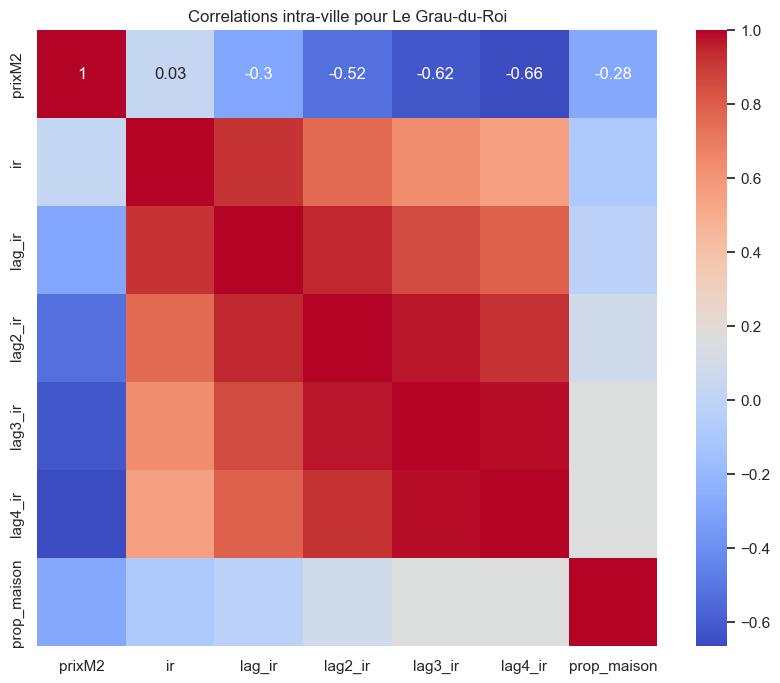

In [90]:
# Intra villes
for i in ["Paris 14","Clermont-Ferrand","Le Grau-du-Roi"]:
  corplot(cor_ville(immo_reg_com_diff, i), i)

Les corrélations avec le taux d'intérêt sont plus fortes, toujours négatives, et généralement plus élevées dans les deux villes de taille supérieur. De plus, la corrélation est plus forte au premier retard à Paris, tandis que pour Clermont-Ferrand et le Grau-du-Roi, elle est plus importante au troisième retard. Cela pourrait indiquer un effet différencié du taux d'intérêt selon la taille de la ville.


### Modèles communaux

Dans le contexte de données de panel, différents problèmes se posent à l'estimateur OLS (MCO en français), souvent appelé Pooled-OLS (cf. On The Pooling Of Time Series And Cross Section Data, Yair Mundlak, 1978). Deux méthodes fréquemment utilisées pour pallier les limites de POLS sont l'estimation avec effets fixes (fixed-effects) ou effets aléatoires (random-effects). Un modèle à effets fixes est privilégié dans ce projet car il permet d'appréhender les variations intra-groupe tout en contrôlant l'hétérogénéité inobservable constante dans le temps (par exemple, la présence d'une rivière dans la ville). Ce choix est également courant dans la littérature sur l'évaluation des biens immobiliers. Pour plus d'informations sur la méthodologie générale appliquée aux données de panel, voir Econometric Analysis of Cross Section and Panel Data, Wooldridge, 2001.

#### Modèle Introductif - Modèle simple du taux d'intérêt

Pour introduire le modèle principal une régression simple est réalisée via un pooled-OLS sans effets croisés (l'utilisation d'effets fixes est pour l'instant impossible car cela controlerait pour toute l'hétérogéinité innobservable constante dans le temps par individu et certaines de nos variables explicatives sont constantes dans le temps) : $$p_{nt}= \beta_0+\beta_iL^3(i_t)+\beta_MM_{nt} + \beta_c X_{nc}+\beta_{D}D+\varepsilon_t$$ avec $p_{nt}$ le prix des appartements et maisons dans ville $n$ à la période t, $L^3(i_t)$ le troisième retard du taux d'interet à la période t, $M_{nt}$ la proportion de maisons dans le total des transactions immobilières à la période t pour la ville n, $X_{nc}$ la matrice des variables des contrôles constante dans le temps pour la ville $n$ (densité de population en km2 en 2019, revenus médian en 2019, accès à un médecin généraliste, taux d'agressions pour 1000, et la différence de densité et de revenus entre respectivement, 2020/2014 et 2019/2014). $D$ est une variable muette servant à controler les effets fixes de chaque trimestre (par exemple, la situation macroéconomique nationale ou les confinements pendant la période covid). 

Ainsi, cette régression a pour objectif de vérifier la cohérence des résultats et d'identifier certains problèmes de données (par exemple des valeurs manquantes au niveau des arrondissements de Paris, Lyon ou Marseille). 

In [91]:
# Model 1a
model1a= 'prixM2 ~ lag3_ir + (popdensity2020 + med_change + Physicist_access + Q219 + prop_maison + assault_for_1000 + dens_change) + prop_maison + C(Date)'
mod1a = run_regression(immo_reg_com_diff, model1a)
test_breuschpagan = het_breuschpagan(mod1a.resid,  mod1a.model.exog)
test_breuschpagan

(44.25803261092212,
 0.5032717936070252,
 1.0796996970432418,
 0.33587581367205754)

Ce modèle ne semble pas souffrir d'hétéroscédasticité (pval=0.5>0.05)

In [92]:
mod1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 prixM2   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     1147.
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:50:22   Log-Likelihood:                -86456.
No. Observations:               10395   AIC:                         1.730e+05
Df Residuals:                   10353   BIC:                         1.733e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3155.3140     71.749    -43.977      0.000   -3295.955   -3014.673
C(Date)[T.20140401]  5.527e-10   1.32e-09      0.420      0.675   -2.03e-09    3.13e-09
C(Date)[T.20140701]   4.48e-10   9.72e-10      0.461      0.645   -1.46e-09    2.35e-09
C(Date)[T.20141001]   741.4130     52.755     14.054      0.000     638.003     844.823
C(Date)[T.20150101]   625.6877     53.350     11.728      0.000     521.110     730.265
C(Date)[T.20150401]   444.0279     54.242      8.186      0.000     337.704     550.352
C(Date)[T.20150701]   368.7592     54.879      6.720      0.000     261.186     476.332
C(Date)[T.20151001]   213.0556     55.505      3.838      0.000     104.255     321.857
C(Date)[T.20160101]   -34.6661     56.149     -0.617      0.537    -144.729      75.397
C(Date)[T.20160401]   -79.5686     56.284     -1.414      0.157    -189.895      30.758
C(Date)[T.20160701]   111.0171     55.973      1.983      0.047       1.299     220.735
C(Date)[T.20161001]   224.4844     56.131      3.999      0.000     114.456     334.513
C(Date)[T.20170101]  -165.5762     56.599     -2.925      0.003    -276.522     -54.631
C(Date)[T.20170401]  -303.3090     56.799     -5.340      0.000    -414.646    -191.972
C(Date)[T.20170701]  -356.7285     56.908     -6.268      0.000    -468.279    -245.177
C(Date)[T.20171001]  -406.4388     56.841     -7.150      0.000    -517.858    -295.019
C(Date)[T.20180101]  -362.7665     56.811     -6.385      0.000    -474.128    -251.405
C(Date)[T.20180401]  -308.1923     56.816     -5.424      0.000    -419.563    -196.822
C(Date)[T.20180701]  -213.7106     56.874     -3.758      0.000    -325.195    -102.227
C(Date)[T.20181001]  -252.2961     56.846     -4.438      0.000    -363.725    -140.867
C(Date)[T.20190101]  -304.7057     56.798     -5.365      0.000    -416.041    -193.371
C(Date)[T.20190401]  -294.3158     56.785     -5.183      0.000    -405.626    -183.005
C(Date)[T.20190701]  -219.6510     56.824     -3.865      0.000    -331.038    -108.264
C(Date)[T.20191001]  -204.5696     56.799     -3.602      0.000    -315.907     -93.233
C(Date)[T.20200101]  -243.9348     56.731     -4.300      0.000    -355.139    -132.731
C(Date)[T.20200401]  -299.0546     56.634     -5.280      0.000    -410.069    -188.041
C(Date)[T.20200701]  -284.5474     56.634     -5.024      0.000    -395.561    -173.534
C(Date)[T.20201001]  -245.7963     56.580     -4.344      0.000    -356.705    -134.888
C(Date)[T.20210101]  -163.8647     56.626     -2.894      0.004    -274.863     -52.866
C(Date)[T.20210401]  -129.3063     56.637     -2.283      0.022    -240.327     -18.286
C(Date)[T.20210701]   -15.4409     56.701     -0.272      0.785    -126.586      95.704
C(Date)[T.20211001]   -84.5082     56.579     -1.494      0.135    -195.413      26.397
C(D

Les résultats confirment l'influence positive de la densité de population et du revenu médian communal sur les prix immobiliers. Les maisons ont généralement un prix au mètre carré inférieur aux appartements, d'où un effet négatif pour la variable maison. Le taux d'intérêt a un impact significatif d'environ -788€ par m² pour un point de taux supplémentaire. La seule surprise vient de la criminalité, qui a un effet positif, capturant peut-être un effet de mobilité de population plus élevé (agressions plus nombreuses dans zones avec plus de passage?).

#### Modèle 1 - Modèle complet avec effets fixes

Le modèle principal de cette analyse, similaire au modèle introductif, se distingue par l'inclusion de coefficients d'interaction entre le taux d'intérêt et les autres variables. Cela permet d'utiliser un modèle à effets fixes, les variables constantes dans le temps devenant dynamiques grâce à l'interaction avec le taux d'intérêt. Le modèle, après application d'une transformation within, devient : $$p_{nt}-\bar{p_{n}}= \beta_0+\beta_i[L^3(i_t)-\bar{L^3(i_t)}]+\beta_M[M_{nt}-\bar{M_{n}}] + \beta_{ic}[L^3(i_t)X_{nc}-\bar{L^3(i)X_{nc}}]+\beta_{im}[L^3(i_t)M_{nt}-\bar{L^3(i)M_{n}}]+\beta^{FE}_{D}D+\varepsilon_t$$ $$\iff \ddot{p_{nt}}= \beta^{FE}_0+\beta^{FE}_i\ddot{L^3(i_t)}+\beta^{FE}_M\ddot{M_{nt}} + \beta^{FE}_{ic}[\ddot{L^3(i_t)X_{nc}}]+\beta^{FE}_{im}[\ddot{L^3(i_t)M_{nt}}]+\beta^{FE}_{D}D+\varepsilon_t$$ Remarque: Inclure une variable muette permet directement d'obtenir l'estimation à effets-fixe (c'est ce qui a été utilisé pour les effets fixe trimestriels) cependant cette approche présente un coût calculatoire élevé avec beaucoup de groupes, la transformation within y est donc souvent préféré (où pour chaque variable est réduite de la moyenne du groupe, ici la ville)

Remarque: La transformation within peut si deux variables d'interactions changent au cours du temps et sous certaines conditions provoquer un biais (voir _Interactions in Fixed Effects Regression Models_, Giesselmann et Schmidt-Catran, 2018). Ce n'est pas le cas pour la plupart de nos coefficients, sauf $\beta_{im}$ qui représente l'intéraction entre le taux d'interet et la proportion de maison dans le total des transactions immobilières

In [93]:
# Model 1b
model1b_formula = 'prixM2_FE ~ lag3_ir_FE+prop_maison_FE + (popdensity2020_ir_FE + med_change_ir_FE + Physicist_access_ir_FE + Q219_ir_FE + assault_for_1000_ir_FE + dens_change_ir_FE + prop_maison_ir_FE) + C(Date)'
mod1b = run_regression(immo_reg_com_diff, model1b_formula)

test_breuschpagan = het_breuschpagan(mod1b.resid,  mod1b.model.exog)
test_breuschpagan

(48.174898561512116,
 0.38492232016983424,
 1.1475950697540669,
 0.23706779610337067)

Ce modèle ne semble pas souffrir d'hétéroscédasticité (pval=0.39>0.05)

In [94]:
mod1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              prixM2_FE   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     82.89
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:50:22   Log-Likelihood:                -81001.
No. Observations:               10395   AIC:                         1.621e+05
Df Residuals:                   10352   BIC:                         1.624e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 17.8098      5.604      3.178      0.001       6.825      28.795
C(Date)[T.20140401]    -1.847e-09   1.69e-10    -10.931      0.000   -2.18e-09   -1.52e-09
C(Date)[T.20140701]     8.362e-09   8.76e-10      9.550      0.000    6.65e-09    1.01e-08
C(Date)[T.20141001]      363.2530     32.092     11.319      0.000     300.346     426.160
C(Date)[T.20150101]      297.3071     32.180      9.239      0.000     234.228     360.386
C(Date)[T.20150401]      177.0987     32.557      5.440      0.000     113.280     240.917
C(Date)[T.20150701]      116.3606     33.142      3.511      0.000      51.396     181.326
C(Date)[T.20151001]       43.0989     33.138      1.301      0.193     -21.859     108.056
C(Date)[T.20160101]     -111.7259     33.356     -3.349      0.001    -177.111     -46.341
C(Date)[T.20160401]     -135.5745     33.410     -4.058      0.000    -201.064     -70.085
C(Date)[T.20160701]      -27.9624     33.486     -0.835      0.404     -93.601      37.676
C(Date)[T.20161001]      137.2771     33.360      4.115      0.000      71.885     202.669
C(Date)[T.20170101]     -152.9168     33.531     -4.561      0.000    -218.643     -87.190
C(Date)[T.20170401]     -221.7003     33.593     -6.600      0.000    -287.549    -155.851
C(Date)[T.20170701]     -260.0736     33.840     -7.685      0.000    -326.408    -193.740
C(Date)[T.20171001]     -273.2087     33.616     -8.127      0.000    -339.103    -207.314
C(Date)[T.20180101]     -225.7309     33.577     -6.723      0.000    -291.549    -159.913
C(Date)[T.20180401]     -194.3573     33.585     -5.787      0.000    -260.191    -128.524
C(Date)[T.20180701]     -133.6939     33.747     -3.962      0.000    -199.844     -67.544
C(Date)[T.20181001]     -144.2936     33.632     -4.290      0.000    -210.218     -78.369
C(Date)[T.20190101]     -149.1049     33.591     -4.439      0.000    -214.950     -83.260
C(Date)[T.20190401]     -122.5932     33.595     -3.649      0.000    -188.446     -56.740
C(Date)[T.20190701]      -72.4165     33.586     -2.156      0.031    -138.252      -6.581
C(Date)[T.20191001]      -43.2845     33.556     -1.290      0.197    -109.060      22.491
C(Date)[T.20200101]      -27.0751     33.656     -0.804      0.421     -93.047      38.896
C(Date)[T.20200401]      -51.6085     33.500     -1.541      0.123    -117.274      14.057
C(Date)[T.20200701]      -52.0446     33.502     -1.553      0.120    -117.715      13.626
C(Date)[T.20201001]        2.7663     33.415      0.083      0.934     -62.733      68.266
C(Date)[T.20210101]       78.5305     33.432      2.349      0.019      12.998     144.063
C(Date)[T.20210401]      113.1581     33.464      3.381      0.001      47.562     178.754
C(Date)[T.20210701]      197.3493     33.533      5.885      0.000     131.618  

Ce modèle suggère qu'une hausse du taux d'intérêt a un effet plus marqué dans les villes densément peuplées, avec une baisse de 0.0248€ des prix au m2 par point de taux d'interet en plus par personne par km2. Pour Paris cet effet serait d'environ 500€ par point de taux d'interet. Concernant les revenus médians, on observe une baisse de 0.0414€ par point d'intérêt supplémentaire pour chaque euros de revenu médian en 2019, soit environ 1200€ de baisse pour Paris. Un effet similaire est observé dans des villes en croissance (économique et démographique). Les villes avec un bon niveau d'accès au soins serait également plus touché comme les villes avec plus d'agressions (variable qui se comporte peut-être comme un proxy des zones métropolitaines), cependant ces deux variables ont une significativité pratique assez faible (l'échelle sur laquelle ces variables sont distribuées est assez petite). Le $R^2$ affiché est "within" c'est à dire qu'il représente la partie de la variance expliquée à l'intérieur du groupe, dans le cas présent notre modèle explique environ 25% de la variance des prix immobilier dans une même ville dans la dimension temporelle. 

Ces résultats semblent cohérents avec l'hypothèse d'effets spéculatifs et/ou de substitutions. Pour vérifier la robustesse de ces résultats plusieurs spécifications supplémentaires sont dévelopées. 

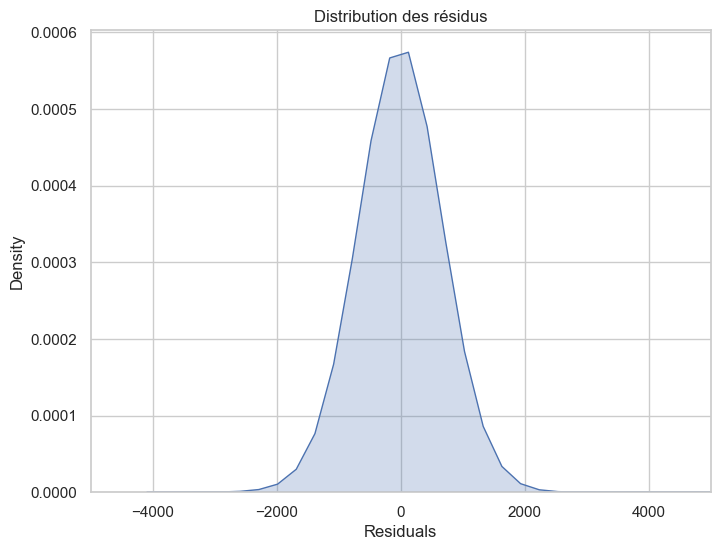

In [95]:
residuals = mod1b.resid
plt.figure(figsize=(8, 6))
sns.kdeplot(residuals, bw_adjust=7, shade=True)  # Adjust bandwidth as needed
plt.title('Distribution des résidus')
plt.xlim(-5000, 5000)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

Les résidus semblent être distribué par une Gaussienne centrée sur 0. 

#### Modèle 1c - Modèle log-niveau

Une critique possible de notre modèle est l'existance d'effets d'échelles relativement fort sur les prix, les prix immobilier pouvant varier fortement d'une ville à une autre. Ce modèle utilise donc une spécification log-niveau.
$$ \ddot{log(p_{nt})}= \beta^{FE}_0+\beta^{FE}_i\ddot{L^3(i_t)}+\beta^{FE}_M\ddot{M_{nt}} + \beta^{FE}_{ic}[\ddot{L^3(i_t)X_{nc}}]+\beta^{FE}_{D}D+\varepsilon_t$$

In [96]:
# Model 1c
model1c_formula = 'log_prixM2_FE ~ lag3_ir_FE+prop_maison_FE + (popdensity2020_ir_FE + med_change_ir_FE + Physicist_access_ir_FE + Q219_ir_FE + assault_for_1000_ir_FE + dens_change_ir_FE + prop_maison_ir_FE) + C(Date)'
mod1c = run_regression(immo_reg_com_diff, model1c_formula)

test_breuschpagan = het_breuschpagan(mod1c.resid,  mod1c.model.exog)
test_breuschpagan

(55.12166249282649,
 0.16776483331784584,
 1.3139591144572174,
 0.0840559971605089)

Ce modèle ne semble pas souffrir d'hétéroscédasticité (pval=0.17>0.05)

In [97]:
mod1c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_prixM2_FE   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     381.7
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:50:23   Log-Likelihood:                 13041.
No. Observations:               10395   AIC:                        -2.600e+04
Df Residuals:                   10352   BIC:                        -2.568e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0049      0.001      7.485      0.000       0.004       0.006
C(Date)[T.20140401]    -1.747e-13   1.99e-14     -8.779      0.000   -2.14e-13   -1.36e-13
C(Date)[T.20140701]     1.279e-12   1.03e-13     12.406      0.000    1.08e-12    1.48e-12
C(Date)[T.20141001]        0.0836      0.004     22.133      0.000       0.076       0.091
C(Date)[T.20150101]        0.0607      0.004     16.007      0.000       0.053       0.068
C(Date)[T.20150401]        0.0322      0.004      8.389      0.000       0.025       0.040
C(Date)[T.20150701]        0.0254      0.004      6.515      0.000       0.018       0.033
C(Date)[T.20151001]        0.0043      0.004      1.096      0.273      -0.003       0.012
C(Date)[T.20160101]       -0.0427      0.004    -10.864      0.000      -0.050      -0.035
C(Date)[T.20160401]       -0.0490      0.004    -12.452      0.000      -0.057      -0.041
C(Date)[T.20160701]       -0.0135      0.004     -3.428      0.001      -0.021      -0.006
C(Date)[T.20161001]       -0.0095      0.004     -2.416      0.016      -0.017      -0.002
C(Date)[T.20170101]       -0.0493      0.004    -12.482      0.000      -0.057      -0.042
C(Date)[T.20170401]       -0.0617      0.004    -15.605      0.000      -0.069      -0.054
C(Date)[T.20170701]       -0.0704      0.004    -17.664      0.000      -0.078      -0.063
C(Date)[T.20171001]       -0.0752      0.004    -19.006      0.000      -0.083      -0.067
C(Date)[T.20180101]       -0.0699      0.004    -17.682      0.000      -0.078      -0.062
C(Date)[T.20180401]       -0.0643      0.004    -16.259      0.000      -0.072      -0.057
C(Date)[T.20180701]       -0.0417      0.004    -10.482      0.000      -0.049      -0.034
C(Date)[T.20181001]       -0.0465      0.004    -11.748      0.000      -0.054      -0.039
C(Date)[T.20190101]       -0.0508      0.004    -12.837      0.000      -0.059      -0.043
C(Date)[T.20190401]       -0.0453      0.004    -11.462      0.000      -0.053      -0.038
C(Date)[T.20190701]       -0.0267      0.004     -6.755      0.000      -0.034      -0.019
C(Date)[T.20191001]       -0.0170      0.004     -4.310      0.000      -0.025      -0.009
C(Date)[T.20200101]       -0.0167      0.004     -4.222      0.000      -0.025      -0.009
C(Date)[T.20200401]       -0.0207      0.004     -5.235      0.000      -0.028      -0.013
C(Date)[T.20200701]       -0.0149      0.004     -3.772      0.000      -0.023      -0.007
C(Date)[T.20201001]        0.0036      0.004      0.918      0.358      -0.004       0.011
C(Date)[T.20210101]        0.0248      0.004      6.289      0.000       0.017       0.032
C(Date)[T.20210401]        0.0395      0.004     10.032      0.000       0.032       0.047
C(Date)[T.20210701]        0.0709      0.004     17.958      0.000       0.063  

Les résultats sont cohérents avec le premier modèle, avec une augmentation significative du $R^2$, indiquant que le modèle explique 60% de la variance du log des prix dans une même commune.

#### Modèle 2 - Modèle avec prix dé-tendanciés

Ce modèle s'attaque au risque de corrélations fallacieuses dû au caractère non stationnaire des prix immobiliers. Il consiste en une estimation en deux étapes, sans inclure d'effets fixes pour simplifier les calculs.
1) Régression des prix sur le temps avec t le nombre de trimestres depuis le début du panel pour chaque groupe : $$ p_{nt}=\beta_0+\beta_{tn}t$$ 

2) Régression des prix réduit de la tendance linéaire estimé sur le taux d'interet et les interactions : $$(p_{nt}-\beta_{nt}\times t)= \beta_0+\beta_iL^3(i_t)+\beta_MM_{nt} + \beta_c X_{nc}+\beta_{ic}L^3(i_t)X_{nc}+\beta_{iM}L^3(i_t)M_{nt}+\beta_{D}D+\varepsilon_t $$

Remarque : enlever la tendance de l'évolution des prix ne permet pas de rendre ce processus stationaire mais réduit tout de même le risque d'obtenir des résultats liée à la hausse des prix sur la période

In [98]:
#DETRENDED REGRESSION
immo_reg_com_diff['time'] = immo_reg_com_diff.groupby('COM').cumcount() + 1
df_reg = immo_reg_com_diff.groupby('COM').apply(lambda x: smf.ols('prixM2 ~ time', data=x).fit().resid + x['prixM2']).reset_index(name='detrended_variable')
reg_immo2 = immo_reg_com_diff.groupby('COM').apply(lambda x: smf.ols('prixM2 ~ time', data=x).fit().params['time']).reset_index(name='estimate')
vroom = immo_reg_com_diff.reset_index(drop=False).merge(reg_immo2, on='COM')
vroom['prixM2_dt'] = vroom['prixM2'] - vroom['time'] * vroom['estimate']

model_detrend= 'prixM2_dt ~ lag_ir * (popdensity2020 + med_change + Physicist_access + Q219 + prop_maison + assault_for_1000 + dens_change) + prop_maison + C(AN)'
mod2 = run_regression(vroom, model_detrend)

test_breuschpagan = het_breuschpagan(mod2.resid,  mod2.model.exog)
test_breuschpagan

(136.52171067971497,
 1.0100350318912537e-17,
 6.171443234986253,
 1.3466629729225007e-18)

Ce modèle souffre d'hétéroscédasticité (p-value=1.08e-17), les résultats sont donc affichés sous forme robuste:

In [99]:
mod2.get_robustcov_results(cov_type='HC2').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              prixM2_dt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     2231.
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:50:25   Log-Likelihood:                -23849.
No. Observations:                2970   AIC:                         4.775e+04
Df Residuals:                    2946   BIC:                         4.789e+04
Df Model:                          23                                         
Covariance Type:                  HC2                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -4050.5405    636.448     -6.364      0.000   -5298.467   -2802.614
C(AN)[T.2015]             -96.2062    178.964     -0.538      0.591    -447.112     254.700
C(AN)[T.2016]            -311.5988    134.436     -2.318      0.021    -575.196     -48.001
C(AN)[T.2017]            -555.9434     77.163     -7.205      0.000    -707.241    -404.645
C(AN)[T.2018]            -513.6880     78.676     -6.529      0.000    -667.954    -359.422
C(AN)[T.2019]            -571.4574     77.552     -7.369      0.000    -723.519    -419.396
C(AN)[T.2020]            -596.5657     90.560     -6.587      0.000    -774.134    -418.998
C(AN)[T.2021]            -455.9793     88.047     -5.179      0.000    -628.619    -283.339
C(AN)[T.2022]            -480.6124     99.339     -4.838      0.000    -675.393    -285.832
C(AN)[T.2023]            -468.4893    112.625     -4.160      0.000    -689.320    -247.658
lag_ir                    505.1551    385.150      1.312      0.190    -250.036    1260.346
popdensity2020              0.1741      0.014     12.505      0.000       0.147       0.201
med_change                 -0.0617      0.135     -0.456      0.649      -0.327       0.204
Physicist_access          -40.5937     49.817     -0.815      0.415    -138.274      57.087
Q219                        0.2682      0.018     14.541      0.000       0.232       0.304
prop_maison              -413.8822    318.896     -1.298      0.194   -1039.163     211.399
assault_for_1000          237.8831     38.171      6.232      0.000     163.038     312.728
dens_change                -0.0821      0.251     -0.327      0.744      -0.575       0.411
lag_ir:popdensity2020      -0.0295      0.008     -3.924      0.000      -0.044      -0.015
lag_ir:med_change           0.0129      0.073      0.177      0.860      -0.130       0.156
lag_ir:Physicist_access     2.2397     26.574      0.084      0.933     -49.865      54.344
lag_ir:Q219                -0.0186      0.010     -1.877      0.061      -0.038       0.001
lag_ir:prop_maison       -249.9338    165.175     -1.513      0.130    -573.803      73.936
lag_ir:assault_for_1000   -32.3233     20.408     -1.584      0.113     -72.339       7.692
lag_ir:dens_change          0.0153      0.136      0.113      0.910      -0.251       0.282
==============================================================================
Omnibus:                     1188.414   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14322.787
Skew:                           1.555   Prob(JB):                         0.00
Kurtosis:                      13.299   Cond. No.                     3.36e+18
==============================================================================

Notes:
[1] Standard Errors are h

Ce modèle à la particularité d'avoir peu de coefficients statistiquement signifactifs mais les effets croisés taux d'interets densité reste significatifs à un niveau inférieur à 1% et l'interactions avec les revenus est significative à un niveau d'environ 6%. De plus, le coefficient associé au chômage semble capter la majorité de l'effet précédemment attribué aux revenus, suggérant que les revenus médians pourraient être un proxy de la santé économique locale.

#### Visualisation des prix sans tendance linéaire

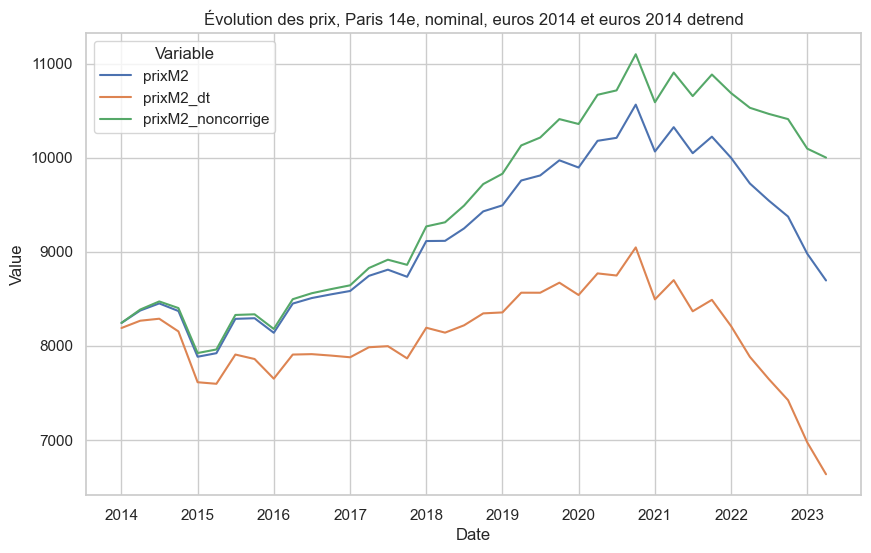

In [100]:
plot_data = vroom[vroom['LIB_COM'].str.startswith('Paris 14')].copy()
plot_data['prixM2_noncorrige'] = plot_data['prixM2'] * plot_data['BASE14']
plot_data['Date'] = pd.to_datetime(plot_data['Date'], format='%Y%m%d')
plot_data_melted = plot_data.melt(id_vars='Date', value_vars=['prixM2', 'prixM2_dt', 'prixM2_noncorrige'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_data_melted, x='Date', y='value', hue='variable')
plt.title("Évolution des prix, Paris 14e, nominal, euros 2014 et euros 2014 detrend")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(title='Variable')
plt.show()

En vert sont représenté les prix non corrigés de l'inflation (jamais utilisé dans le cadre de cette modélisation), en bleu les prix en euros 2014 et en orange les prix sans tendance linéaire.

### Modèle ZE (Zone d'Emploi)

#### Modèle 3 - Spécification ZE du modèle complet

Dans ce modèle, la zone d'emploi remplace la ville comme unité d'analyse, avec l'ajout du taux de chômage au même retard que le taux d'interet pour simplifier l'interprétation.

$$\ddot{p_{nt}}= \beta^{FE}_0+\beta^{FE}_i\ddot{L^3(i_t)}+\beta^{FE}_V\ddot{Z_{nt}} + \beta^{FE}_{IC}[\ddot{L^3(i_t)X_{nc}}]+\beta^{FE}_{IV}[\ddot{L^3(i_t)Z_{nt}}]+\beta^{FE}_{D}D+\varepsilon_t$$
 $Z_{nt}$ inclus toutes les charactéristiques variante dans le temps par zone d'emploi (ie. chomage et proportion de maisons vendues dans le total). 

In [101]:
# Part 4: Linear Regression Models
# Model mod3
mod3_formula = 'prixM2_FE ~ lag3_ir_FE+prop_maison_FE+lag3_UNEMP_FE+lag3_UNEMP_ir_FE + (popdensity2020_ir_FE + med_change_ir_FE + Physicist_access_ir_FE + Q219_ir_FE + assault_for_1000_ir_FE + dens_change_ir_FE + prop_maison_ir_FE) + C(Date)'
mod3 = run_regression(immo_reg_ze_diff, mod3_formula)

test_breuschpagan = het_breuschpagan(mod3.resid,  mod3.model.exog)
test_breuschpagan

(571.3553251345922,
 1.0983410725053175e-90,
 13.912285725936322,
 6.968799331004072e-97)

Ce modèle souffre également d'hétéroscédasticité (p-value=8.73e-91), les résultats sont donc affichés sous forme robuste:

In [102]:
mod3.get_robustcov_results(cov_type='HC2').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              prixM2_FE   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     237.4
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:50:25   Log-Likelihood:                -47773.
No. Observations:                7945   AIC:                         9.564e+04
Df Residuals:                    7900   BIC:                         9.595e+04
Df Model:                          44                                         
Covariance Type:                  HC2                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.2667      1.090      4.832      0.000       3.130       7.403
C(Date)[T.20140401]    -5.582e-11   6.88e-12     -8.108      0.000   -6.93e-11   -4.23e-11
C(Date)[T.20140701]      2.86e-08   2.86e-09      9.989      0.000     2.3e-08    3.42e-08
C(Date)[T.20141001]       85.6108      9.956      8.599      0.000      66.095     105.127
C(Date)[T.20150101]       56.8342      9.451      6.013      0.000      38.307      75.361
C(Date)[T.20150401]       30.4168      8.599      3.537      0.000      13.560      47.274
C(Date)[T.20150701]       41.8229      7.834      5.339      0.000      26.467      57.179
C(Date)[T.20151001]       19.0632      6.683      2.852      0.004       5.963      32.164
C(Date)[T.20160101]      -38.8345      7.074     -5.490      0.000     -52.702     -24.967
C(Date)[T.20160401]      -40.1071      6.629     -6.051      0.000     -53.101     -27.113
C(Date)[T.20160701]        4.0791      5.917      0.689      0.491      -7.519      15.678
C(Date)[T.20161001]       -6.4596      6.042     -1.069      0.285     -18.303       5.384
C(Date)[T.20170101]      -47.7493      6.010     -7.944      0.000     -59.531     -35.967
C(Date)[T.20170401]      -62.1940      6.553     -9.490      0.000     -75.040     -49.348
C(Date)[T.20170701]      -53.3019      8.221     -6.484      0.000     -69.416     -37.187
C(Date)[T.20171001]      -75.9134      6.356    -11.943      0.000     -88.374     -63.453
C(Date)[T.20180101]      -93.7485      6.220    -15.072      0.000    -105.942     -81.555
C(Date)[T.20180401]      -88.4947      6.497    -13.620      0.000    -101.231     -75.759
C(Date)[T.20180701]      -55.9616      6.452     -8.674      0.000     -68.609     -43.314
C(Date)[T.20181001]      -59.6378      7.265     -8.209      0.000     -73.878     -45.397
C(Date)[T.20190101]      -94.8307      4.538    -20.896      0.000    -103.727     -85.934
C(Date)[T.20190401]      -93.2901      3.950    -23.621      0.000    -101.032     -85.548
C(Date)[T.20190701]      -59.3079      4.111    -14.425      0.000     -67.367     -51.249
C(Date)[T.20191001]      -52.9633      3.656    -14.485      0.000     -60.131     -45.796
C(Date)[T.20200101]      -86.3606      4.472    -19.310      0.000     -95.128     -77.594
C(Date)[T.20200401]      -90.5074      4.793    -18.883      0.000     -99.903     -81.112
C(Date)[T.20200701]      -74.3302      5.034    -14.765      0.000     -84.198     -64.462
C(Date)[T.20201001]      -48.6720      5.429     -8.965      0.000     -59.314     -38.030
C(Date)[T.20210101]      -33.2944      7.725     -4.310      0.000     -48.438     -18.151
C(Date)[T.20210401]       46.0564      6.838      6.736      0.000      32.653      59.460
C(Date)[T.20210701]       89.4946      7.545     11.861      0.000      74.704  

Les résultats sont cohérents avec nos résultats précédents mais on remarque que le coefficients associés au chomage capture la majorité de l'effet précédement attribué aux revenus. Il semblerait que les revenus médians soit un proxy général de la santé économique locale.

### Modèles EPCI (Établissement Public de Coopération Intercommunale)

#### Modèle 4 - Spécification EPCI du modèle complet

$$\ddot{p_{nt}}= \beta^{FE}_0+\beta^{FE}_i\ddot{L^3(i_t)}+\beta^{FE}_M\ddot{M_{nt}} + \beta^{FE}_{IC}[\ddot{L^3(i_t)X_{nc}}]+\beta^{FE}_{IM}[\ddot{L^3(i_t)M_{nt}}]+\beta^{FE}_{D}D+\varepsilon_t$$

In [103]:
# Model mod5
mod5_formula = 'prixM2_FE ~ lag3_ir_FE+prop_maison_FE + (popdensity2020_ir_FE + med_change_ir_FE + Physicist_access_ir_FE + Q219_ir_FE + assault_for_1000_ir_FE + dens_change_ir_FE + prop_maison_ir_FE) + C(Date)'
mod5 = run_regression(immo_reg_epci_diff, mod5_formula)

test_breuschpagan = het_breuschpagan(mod5.resid,  mod5.model.exog)
test_breuschpagan

(320.39154355963484,
 8.771648845243717e-43,
 7.996554911084513,
 3.0909886558419083e-46)

Le modèle souffre d'hétéroscédasticité (p-value=6.27e-43), les résultats sont donc affichés sous forme robuste:

In [104]:
mod5.get_robustcov_results(cov_type='HC2').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              prixM2_FE   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     259.3
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:50:25   Log-Likelihood:                -28189.
No. Observations:                4095   AIC:                         5.647e+04
Df Residuals:                    4051   BIC:                         5.674e+04
Df Model:                          43                                         
Covariance Type:                  HC2                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 31.7507      3.655      8.688      0.000      24.586      38.916
C(Date)[T.20140401]    -1.996e-07   1.88e-07     -1.059      0.289   -5.69e-07     1.7e-07
C(Date)[T.20140701]     8.869e-07   8.05e-07      1.101      0.271   -6.92e-07    2.47e-06
C(Date)[T.20141001]    -1333.8528   1638.507     -0.814      0.416   -4546.227    1878.522
C(Date)[T.20150101]    -1309.6555   1526.316     -0.858      0.391   -4302.074    1682.763
C(Date)[T.20150401]    -1213.8353   1301.881     -0.932      0.351   -3766.237    1338.566
C(Date)[T.20150701]    -1034.5414   1077.702     -0.960      0.337   -3147.430    1078.348
C(Date)[T.20151001]     -920.2420    879.662     -1.046      0.296   -2644.864     804.380
C(Date)[T.20160101]     -805.2386    599.375     -1.343      0.179   -1980.342     369.865
C(Date)[T.20160401]     -760.5953    521.310     -1.459      0.145   -1782.650     261.459
C(Date)[T.20160701]     -742.6058    670.368     -1.108      0.268   -2056.896     571.684
C(Date)[T.20161001]     -722.9851    603.249     -1.198      0.231   -1905.685     459.715
C(Date)[T.20170101]     -484.3213    285.832     -1.694      0.090   -1044.709      76.066
C(Date)[T.20170401]     -267.8335     20.797    -12.878      0.000    -308.607    -227.060
C(Date)[T.20170701]      -78.8691    189.841     -0.415      0.678    -451.063     293.325
C(Date)[T.20171001]      -85.0986    219.969     -0.387      0.699    -516.358     346.161
C(Date)[T.20180101]      -75.6629    148.851     -0.508      0.611    -367.493     216.167
C(Date)[T.20180401]      -84.0109     89.445     -0.939      0.348    -259.373      91.351
C(Date)[T.20180701]        3.5130     96.986      0.036      0.971    -186.632     193.658
C(Date)[T.20181001]       38.3950    134.608      0.285      0.775    -225.510     302.300
C(Date)[T.20190101]       46.7622    173.525      0.269      0.788    -293.442     386.967
C(Date)[T.20190401]      160.1810    214.196      0.748      0.455    -259.760     580.122
C(Date)[T.20190701]      272.4573    247.798      1.100      0.272    -213.363     758.278
C(Date)[T.20191001]      289.4694    242.268      1.195      0.232    -185.510     764.448
C(Date)[T.20200101]      401.7497    313.729      1.281      0.200    -213.331    1016.830
C(Date)[T.20200401]      535.6179    462.612      1.158      0.247    -371.356    1442.592
C(Date)[T.20200701]      690.8826    585.573      1.180      0.238    -457.163    1838.928
C(Date)[T.20201001]      745.5944    600.650      1.241      0.215    -432.010    1923.199
C(Date)[T.20210101]      678.6122    503.716      1.347      0.178    -308.949    1666.173
C(Date)[T.20210401]      690.7713    473.785      1.458      0.145    -238.108    1619.650
C(Date)[T.20210701]      813.8311    511.497      1.591      0.112    -188.985  

L'estimation du modèle au niveau EPCI révèle des résultats similaires, bien que l'effet total du taux d'intérêt soit réduit, à cause du coefficient associé à $E[B^{FE}_i|(\ddot{L^3(i_t)X_{nc}})=0]$  qui est positif et est égal à 1882€ même si celui-ci n'est pas significatif à 5%. Par ailleurs, l'impact de l'évolution des revenus est plus prononcé que dans les autres modèles.

## Partie IV - Conclusion

Notre analyse économétrique a exploré les effets différenciés de la hausse récente des taux d'intérêt sur les marchés immobiliers locaux, en se concentrant sur les caractéristiques spécifiques de chaque commune, zone d'emploi (ZE), et établissement public de coopération intercommunale (EPCI).

Ainsi, nous avons montré que les effets de la hausse des taux d'intérêt varient considérablement en fonction des caractéristiques locales. Dans des villes densément peuplées, une augmentation des taux d'intérêt entraîne une baisse significative des prix immobiliers. À l'inverse, dans des zones avec un faible niveau de densité de population, l'impact est moins prononcé voir nul. L’évolution positive de la densité, une croissance de la population sur la période 2014-2020, augmente également l’effet négatif du taux d’intérêt. 

En plus de la densité, les revenus médians jouent un rôle important dans la transmission du taux d'intérêt sur les prix immobiliers. Les communes avec des revenus médians plus élevés vont  ressentir des effets plus marqués. 

Les revenus sont potentiellement un indicateur général du dynamisme économique local, dans le modèle ZE, l'inclusion du taux de chômage a capturé la majeure partie de l’effet croisé revenus médians, taux d'intérêt sur les prix immobiliers, or le taux de chômage reflète mieux la situation économique locale que les revenus ou le delta de revenus, ceux-ci variants moins dans le temps. La protection sociale en France réduit par ailleurs ces variations.

Nous avons également montré, que la taille de la commune influe sur la réactivité des prix immobiliers aux changements de taux d'intérêt. Les grandes villes semblent plus sensibles aux variations de taux, probablement à cause de marchés immobiliers plus dynamiques et d'une plus grande spéculation.

Les caractéristiques locales telles que l'accès aux soins et le niveau de criminalité ont également un impact, mais ni le signe ni l’importance de cet effet ne peut-être mesuré précisément avec nos données, les différents modèles nous offrants des interprétations différentes et/ou non conclusives. 

Nous pensons que ces observations sont la conjonction de deux effets, un effet spéculation et un effet substitution. Les grandes villes ayant des marchés, très liquides, dynamiques et naturellement attractifs offrent des rendements potentiels intéressants en période de taux bas, les investisseurs achètent donc sur ces marchés en cas de hausse des taux cette demande diminue (effet spéculation). Par ailleurs, le renchérissement du crédit impacte fortement la capacité d’emprunt des investisseurs qui doivent donc se tourner vers des zones généralement moins attractives, créant une légère pression positive sur les zones moins attractives.
